<a href="https://colab.research.google.com/github/kadefue/MoEST/blob/main/MoEST_Modeling_for_Secondary_School_Per_Subjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Comprehensive Overview of Secondary School Enrollment Forecasting

This notebook provides a complete pipeline for forecasting secondary school enrollment in Tanzania from 2026 to 2030. The analysis integrates various datasets related to enrollment, dropout rates, re-entry, disabilities, school infrastructure (tables, chairs, ICT, electricity, laboratories), and geographical information.

**The pipeline consists of the following key stages:**

1.  **Data Loading and Initial Inspection**: All relevant CSV files are loaded into pandas DataFrames, and a preliminary inspection of their structure and content is performed.
2.  **Data Cleaning and Standardization**: This stage focuses on ensuring data quality by:
    *   Converting object columns to numeric where appropriate.
    *   Dropping irrelevant 'Unnamed' columns.
    *   Standardizing column names (e.g., 'Year', 'Region', 'Council') to facilitate merging and analysis.
    *   Removing certain datasets (e.g., related to primary education, teachers, population) that are not directly relevant to secondary school enrollment forecasting.
3.  **Geographical Enrichment**: Local Government Authority (LGA) status (Urban/Rural) and geographical coordinates (Latitude, Longitude) are obtained for each council. These coordinates are then used to perform K-Means clustering, categorizing councils into geographical clusters. The LGA status and cluster information are merged into all relevant datasets.
4.  **Feature Engineering**: This is a critical step where raw data is transformed into features suitable for machine learning models. Key features include:
    *   **Cohort Tracking**: Linking students from one form/grade in a given year to the next form/grade in the subsequent year to capture student progression.
    *   **Lagged Enrollment**: Previous years' enrollment figures to model trends.
    *   **Year-over-Year Growth**: Measuring the percentage change in enrollment.
    *   **Infrastructure Ratios**: Features derived from available tables, computers, electricity access, and laboratory facilities.
    *   **Dropout Causes**: Including truancy, pregnancy, and indiscipline.
    *   **Re-entry and Disability Data**: Indicators for re-enrolled students and students with disabilities.
    *   **Temporal Features**: Such as election years, which might influence policy and enrollment.
5.  **Model Training and Evaluation**: Advanced machine learning models, specifically XGBoost and LightGBM, are trained on the prepared historical data (2016-2023). The models' performance is evaluated using metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared (R2), and Mean Absolute Percentage Error (MAPE) on a hold-out test set (2024-2025).
6.  **Recursive Forecasting (2026-2030)**: The trained models are used to generate future enrollment predictions. This is done recursively, where predictions for one year become inputs for predicting the next year, mimicking the real-world progression of students.
7.  **Visualization and Interpretation**: The historical and forecasted enrollment trends are visualized through various plots, including:
    *   National-level enrollment trajectory.
    *   Stacked area charts showing enrollment composition by form (Form 1-6).
    *   Bar charts highlighting predicted top regions by enrollment.
    *   Individual trend lines for a randomly selected sample of councils, providing granular insights.
    *   An interactive Folium map displaying geographical clusters and embedding individual council forecast plots for easy exploration.
8.  **Output Generation**: The final forecasts are presented in both long and wide formats and exported to CSV files for further use.

This comprehensive approach aims to provide robust and actionable insights into future secondary school enrollment, supporting strategic planning and resource allocation in the Tanzanian education sector.

### Mount Google Drive and Import Pandas

This initial step is crucial for any Colab notebook that needs to interact with files stored in Google Drive. By executing `drive.mount('/content/drive/')`, we establish a connection to your personal Google Drive, making its contents accessible within this notebook's environment. The `import pandas as pd` line brings in the powerful pandas library, which is the cornerstone for data manipulation and analysis in Python. It's aliased as `pd` for convenience, a common convention in the data science community.

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### List Available Data Files

Before loading any data, it's good practice to inspect the contents of the directory where your data files are stored. This cell uses a shell command `!ls` (list directory contents) to display all files within the `/content/drive/MyDrive/GUIDELINES_TSC_JAN2026/Data Set/csvs/` path. This helps confirm that all expected CSV files are present and provides their exact names, which are necessary for accurate loading.

### Filter CSV Files for Secondary Education Data

This cell is responsible for intelligently selecting only the relevant CSV files for secondary school enrollment forecasting. It starts by listing all files in the specified directory. Then, it applies a filtering logic: it excludes any files whose names contain keywords such as 'Primary', 'Textbooks', 'Population', 'Teacher', 'COBET', or 'Vocational' (case-insensitive). This ensures that the analysis focuses solely on secondary education data, preventing the loading of unnecessary or misleading information. The names of the selected files are then printed to confirm the filtering process.

### Load Filtered CSVs into Pandas DataFrames

After identifying the relevant CSV files, this cell proceeds to load each of them into a pandas DataFrame. It iterates through the `filtered_files` list, constructs the full file path, and uses `pd.read_csv()` to ingest the data. Each DataFrame is then stored in a Python dictionary named `loaded_dataframes`, with the filename (without the `.csv` extension) serving as its key. This creates an organized collection of all raw secondary education datasets, ready for further processing.

### Initial Inspection of Loaded DataFrames

To get a quick understanding of the structure and content of the newly loaded DataFrames, this cell iterates through each DataFrame in the `loaded_dataframes` dictionary. For each DataFrame, it prints:
-   The first 5 rows using `.head()`, which offers a visual preview of the data.
-   A summary of its information using `.info()`, including the column names, non-null counts, and data types.
This step is crucial for identifying immediate issues like incorrect data types, missing values, or unexpected column names before proceeding with detailed cleaning and feature engineering.

### General Data Cleaning and Standardization

This cell performs essential data cleaning and standardization across all loaded DataFrames. It addresses two common issues:

1.  **Numeric Conversion**: It attempts to convert 'object' type columns that appear to contain numerical data (e.g., numbers stored as strings, possibly with commas) into a numeric data type. This is done by removing commas and coercing values to numeric, with errors handled gracefully (non-convertible values become NaN). This ensures mathematical operations can be performed correctly.
2.  **Dropping 'Unnamed' Columns**: It identifies and removes columns like 'Unnamed: 6' that are often generated during CSV export and typically contain mostly null values. Columns with more than 90% nulls are dropped to reduce noise and unnecessary memory usage.

After cleaning, the updated `df.info()` is printed for each DataFrame to show the changes in data types and column structure.

### Initial Consistency Check of Core Columns

This cell performs an initial validation of core identifying columns across all DataFrames: 'Year', 'Region', and 'Council'. It checks for:

-   **Missing Columns**: Verifies if expected column names or their variations (e.g., 'YEAR', 'REGION') are present.
-   **Inconsistent Data Types**: Ensures 'Year' is numeric and 'Region'/'Council' are object/string types, which is critical for merging and analysis.
-   **Null Values**: Identifies if any of these critical columns contain missing values, which could cause issues in later processing steps.

Discrepancies are reported for each DataFrame, highlighting potential problems that need to be addressed before merging.

### Removing Irrelevant DataFrames (Teacher and Population Data)

This cell reinforces the filtering applied earlier by specifically removing any DataFrames from the `loaded_dataframes` dictionary whose names contain the keywords 'Teacher' or 'Population' (case-insensitive). While initial filtering already targeted this, this step acts as a safeguard. The goal is to ensure that only datasets directly pertinent to secondary school enrollment forecasting remain, streamlining the data collection for the modeling phase.

### Prepare 'LGAs Urban and Rural Status' DataFrame

This cell specifically prepares the `LGAs Urban and Rural Status` DataFrame for integration with other datasets. It performs the following transformations:

1.  **Drop 'Remarks'**: Removes the 'Remarks' column as it typically contains free-form text or metadata not directly useful for quantitative analysis.
2.  **Rename 'Classification'**: Renames the 'Classification' column to 'LGA_Status' for clarity and consistency.
3.  **Standardize Case**: Converts both 'Region' and 'Council' column values to uppercase. This ensures uniform matching when merging with other DataFrames that might have varying casing for these identifiers.

After these operations, the cleaned and standardized `df_lga_status` is displayed, ready for merging.

### Merge LGA Status into All Relevant DataFrames

This cell iterates through each DataFrame in `loaded_dataframes` (excluding `df_lga_status` itself) and merges the `LGA_Status` information into it. This is a crucial step for geographical enrichment. The process involves:

1.  **Identifying Key Columns**: Dynamically finds the 'Region' and 'Council' columns in each DataFrame, accounting for potential casing variations.
2.  **Standardizing Case**: Converts the 'Region' and 'Council' values in the target DataFrame to uppercase to ensure a successful match with `df_lga_status`.
3.  **Performing Left Merge**: Uses a `left_on` merge to add the `LGA_Status` to each DataFrame, linking based on the standardized 'Region' and 'Council' columns. This preserves all rows from the original DataFrame while adding the new geographical classification.
4.  **Cleaning Duplicates**: Drops any redundant 'Region' or 'Council' columns that might have been created during the merge.

This enriches all relevant datasets with an 'Urban' or 'Rural' classification, which can be a valuable feature for modeling.

### Post-Merge Consistency Check on Core Columns

Following the merge of `LGA_Status` into the DataFrames, this cell performs another thorough consistency check on the 'Year', 'Region', and 'Council' columns. This re-validation is important to ensure that the merge operation did not introduce any new issues or exacerbate existing ones. It systematically checks for:

-   **Missing Columns**: Confirms the presence of essential identifier columns.
-   **Inconsistent Data Types**: Verifies that 'Year' remains numeric and 'Region'/'Council' are string types.
-   **Null Values**: Detects any nulls in these critical columns that might have appeared due to mismatches during the merge or other processing steps.

All identified discrepancies are collected and printed, providing a clear overview of any remaining data quality concerns in these core attributes.

### Remove 'LGAs Urban and Rural Status' DataFrame

After successfully merging the `LGA_Status` information into all relevant DataFrames, the original `LGAs Urban and Rural Status` DataFrame is no longer needed as a standalone object. This cell explicitly removes it from the `loaded_dataframes` dictionary to free up memory and keep the collection of DataFrames concise and focused on the merged data. It prints messages confirming its removal or indicating if it was already absent.

### Remove 'Pre-primary GER NA NER 2017-2025' DataFrame (Precautionary)

This cell attempts to remove a specific DataFrame, 'Pre-primary GER NA NER 2017-2025', from the `loaded_dataframes` dictionary. Although earlier filtering steps are designed to exclude primary and pre-primary data, this acts as an explicit precautionary measure. It ensures that no pre-primary enrollment data, which is not relevant for secondary school forecasting, remains in the active dataset collection.

### Handle Null Values in 'Region' and 'Council' Columns

This cell systematically addresses null values within the crucial 'Region' and 'Council' columns across all DataFrames. It iterates through each DataFrame, identifies the correct 'Region' and 'Council' column names (handling case variations), and then uses `dropna(subset=[...])` to remove any rows where these identified columns have missing values. This step is critical because 'Region' and 'Council' serve as primary keys for merging and grouping, and rows with nulls in these columns cannot be accurately linked or analyzed. A confirmation message indicates how many rows were dropped, ensuring data integrity for subsequent operations.

### Identify Core Columns and Numerical Metrics for Each DataFrame

This cell is designed to systematically categorize the columns within each DataFrame, distinguishing between core identifying columns and numerical metrics that will be used for modeling. It performs the following:

1.  **Defines `core_columns_mapping`**: A dictionary specifying variations of 'Year', 'Region', and 'Council' column names.
2.  **Iterates and Identifies Core Columns**: For each DataFrame, it searches for these core columns and stores their actual names.
3.  **Identifies Numerical Metrics**: It then identifies all columns with numeric data types that are *not* among the core columns or year column. These represent the quantitative features and target variables.

The results are stored in `dataframe_features`, a dictionary mapping each DataFrame name to a list of its core columns and numerical metrics. This structured output is vital for automated feature selection and ensuring correct column handling during model training.

### Geocoding and Location Consolidation

This cell performs a critical step in geographical data enrichment: acquiring latitude and longitude coordinates for each unique region/council combination. Here's how it works:

1.  **Consolidate Unique Locations**: It extracts all unique 'Region' and 'Council' pairs from *all* loaded DataFrames, ensuring consistent casing.
2.  **Prepare Search Queries**: For each unique location, it constructs a precise search query (e.g., 'Arusha City Council, Arusha, Tanzania') to improve geocoding accuracy.
3.  **Geocode Locations**: Using `geopy.geocoders.Nominatim` with a `RateLimiter` (to respect API usage policies), it queries an online service to obtain latitude and longitude. The `tanzania_council_geodata.csv` file is used for caching, preventing redundant API calls if the process is re-run.
4.  **Finalize Geodata DataFrame**: The obtained coordinates are added to the `geo_data_final` DataFrame, which is then saved to a CSV file. This enriched dataset will be used for spatial analysis and clustering.

### Perform K-Means Clustering on Geographical Coordinates

Building upon the geocoded locations, this cell applies K-Means clustering to group councils based on their geographical proximity. The process is as follows:

1.  **Data Preparation**: Ensures 'Latitude' and 'Longitude' columns are numeric and handles any remaining nulls by dropping those rows, as coordinates are essential for clustering.
2.  **Select Features**: The `X` variable is created, containing only the 'Latitude' and 'Longitude' for clustering.
3.  **Instantiate K-Means**: A `KMeans` model is initialized with `n_clusters` (here, 5) and a `random_state` for reproducibility.
4.  **Fit and Predict**: The model is trained on the coordinates, and each council is assigned a `Geo_Cluster` label, indicating its geographical group. This `Geo_Cluster` column is added back to the `geo_data` DataFrame.

This step creates a new categorical feature that captures spatial relationships, which can be valuable for downstream modeling.

### Merge Geographical Clusters into All Relevant DataFrames

Following the K-Means clustering, this cell integrates the newly generated `Geo_Cluster` information into all other DataFrames within `loaded_dataframes`. This is similar to the `LGA_Status` merge and ensures that each record in every dataset is enriched with its corresponding geographical cluster ID. The steps include:

1.  **Identify and Standardize Key Columns**: Locates and converts 'Region' and 'Council' columns to uppercase in each DataFrame for consistent merging.
2.  **Perform Left Merge**: Merges the `Geo_Cluster` column from the `geo_data` DataFrame, using 'Region' and 'Council' as keys.
3.  **Clean Duplicate Columns**: Removes any redundant 'Region' or 'Council' columns resulting from the merge.

This process adds a powerful spatial feature to all relevant datasets, enabling models to potentially capture geographical patterns in enrollment.

### Verify Geo_Cluster Integration in Selected DataFrames

This cell acts as a crucial verification step to confirm the successful integration of the `Geo_Cluster` information into the DataFrames. It selects specific DataFrames (e.g., 'Data-Secondary Enrollment 2016-2025') and performs a quick inspection:

-   **Checks for DataFrame Existence**: Ensures the selected DataFrame is indeed present in `loaded_dataframes`.
-   **Displays Head**: Shows the first 5 rows to visually confirm the presence and values of the `Geo_Cluster` column.
-   **Prints Info**: Provides the DataFrame's `.info()` summary to check the data type and non-null count of `LGA_Status` and `Geo_Cluster`.

This helps ensure that the geographical enrichment steps have been completed correctly before proceeding to more complex analysis.

### Analyze Key Metrics by Geographical Cluster

This cell performs an exploratory analysis to understand the characteristics of each `Geo_Cluster` based on selected numerical metrics. It uses a predefined dictionary `dfs_to_analyze` to specify which DataFrames and which metrics within those DataFrames should be examined. For each specified metric, it:

1.  **Groups by `Geo_Cluster`**: Aggregates data by the geographical clusters.
2.  **Calculates Descriptive Statistics**: Computes the mean, median, and standard deviation for each metric within each cluster.

This output helps reveal if there are significant differences in enrollment, infrastructure, or other factors across the different geographical clusters, providing insights into potential regional disparities or trends.

### Import Visualization Libraries

This cell is a straightforward but essential step for preparing to create graphical representations of the data. It imports:

-   `matplotlib.pyplot` as `plt`: The foundational plotting library in Python, used for creating a wide variety of static, interactive, and animated visualizations.
-   `seaborn` as `sns`: A high-level data visualization library based on Matplotlib, which provides a more attractive and informative statistical graphics interface.

These libraries will be used in subsequent cells to visualize the geographical clusters and their characteristics.

### Visualize Geographical Cluster Characteristics

This cell generates a series of visualizations to explore and understand the distinct characteristics of the `Geo_Cluster` groups. It leverages the `cluster_analysis_results` from the previous step and the original `loaded_dataframes`:

1.  **Bar Plots of Mean Metrics**: For each DataFrame and selected metric, it creates bar plots showing the *mean* value of that metric for each `Geo_Cluster`. This provides a direct comparison of average values across clusters.
2.  **Box Plots for Distribution**: It then generates box plots for the same metrics, illustrating the *distribution* (median, quartiles, and outliers) of each metric within each `Geo_Cluster`. This helps to understand not just the average, but also the spread and variability of data points within each cluster.

These plots are crucial for interpreting what makes each geographical cluster unique in terms of secondary school enrollment and related factors.

### Geographical Scatter Plot of Clusters

This cell creates a clear geographical scatter plot to visually represent the clusters identified by K-Means. It uses `seaborn.scatterplot` to plot each council's `Longitude` and `Latitude`, with points colored according to their `Geo_Cluster` assignment. The plot helps to:

-   **Visualize Spatial Grouping**: Understand how the councils are grouped geographically.
-   **Identify Cluster Locations**: Pinpoint the general areas covered by each cluster.

This static visualization provides an intuitive overview of the spatial distribution of the generated clusters across Tanzania.

### Interactive Folium Map of Geocoded Locations

This cell generates an interactive geographical map using the `folium` library. This map provides a dynamic way to explore the geocoded locations of the councils:

1.  **Map Initialization**: A Folium map is created, centered on Tanzania, with an appropriate zoom level.
2.  **Marker Clusters**: `MarkerCluster` is used to group nearby markers, improving readability when many points are close together.
3.  **Add Markers**: For each unique region/council with valid latitude and longitude, a marker is placed on the map. Each marker is configured with:
    -   A `popup` displaying the region and council name.
    -   A `tooltip` for quick identification on hover.

This interactive map allows users to pan, zoom, and click on individual locations to see their details, offering a rich geographical context for the data.

### Identify Numerical Columns for Outlier Treatment

This cell systematically prepares a list of numerical columns in each DataFrame that are candidates for outlier detection and treatment. It's designed to be robust:

1.  **Initialization**: An empty dictionary `numerical_cols_for_outlier_treatment` is created to store the results.
2.  **Exclusion List**: A `exclude_cols` list is defined containing common identifier or categorical columns that should not be treated for numerical outliers (e.g., 'Year', 'Region_ENC', 'Geo_Cluster').
3.  **Iteration and Filtering**: For each DataFrame, it identifies all numerical columns. Then, it filters this list, excluding any column whose name matches an entry in the `exclude_cols` list. This ensures that only relevant quantitative metrics are considered for outlier analysis.

The resulting dictionary provides a clear overview of which columns in each DataFrame require attention for potential outliers.

### Final DataFrame Structure Overview

This cell provides a comprehensive overview of the current state of all DataFrames in the `loaded_dataframes` dictionary after all cleaning, merging, and feature engineering steps. For each DataFrame, it calls `df.info()`, which outputs:

-   **Class and Index Type**: Basic DataFrame information.
-   **Number of Entries**: Total rows.
-   **Column Details**: For each column: its name, the number of non-null values, its data type (Dtype).
-   **Memory Usage**: An estimate of the memory consumed by the DataFrame.

This detailed summary is crucial for a final check of data types, null value counts, and overall data integrity before proceeding to model training and forecasting.

### Secondary School Forecasting Pipeline: Data Preparation, Feature Engineering, and Model Training

This extensive cell orchestrates the initial phase of the secondary school enrollment forecasting pipeline, encompassing data preparation, feature engineering, and model training/evaluation. It's structured into several key components:

1.  **`standard_cols(df)`**: A utility function to ensure consistent column naming by converting them to uppercase and stripping whitespace.
2.  **`prepare_secondary_datasets(...)`**: This function takes all raw secondary education DataFrames and performs initial cleaning and aggregation:
    -   **Reshapes Enrollment**: Converts the wide-format enrollment data (with separate columns for each form) into a long format, making it suitable for time-series analysis.
    -   **Aggregates Features**: Summarizes re-entry, disability, and infrastructure data (tables, computers, electricity, laboratories) at the `YEAR`, `REGION`, `COUNCIL` level.
3.  **`engineer_secondary_features(...)`**: This is where the core predictive features are created:
    -   **Merges All Data**: Combines the enrollment data with aggregated infrastructure and social factors (dropout, re-entry, disability).
    -   **Temporal Features**: Adds `IS_ELECTION_YEAR` as a potential influencing factor.
    -   **Lagged Features**: Calculates `LAG_1` and `LAG_2` (enrollment from previous years) and `YOY_GROWTH` to capture trends.
    -   **Cohort Logic**: Implements a sophisticated mechanism to track student progression from one form in a given year to the next form in the subsequent year (`COHORT_LAG`), handling entry points like Form 1 and Form 5, and filling missing values with -1 to signal a specific state to tree-based models.
4.  **`calculate_metrics(...)`**: A helper to compute standard regression evaluation metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared (R2), and Mean Absolute Percentage Error (MAPE).
5.  **`train_secondary_models(df)`**: Trains the forecasting models:
    -   **Label Encoding**: Encodes 'REGION' and 'COUNCIL' into numerical representations for model consumption.
    -   **Feature Selection**: Defines the set of features to be used for training.
    -   **Train/Test Split**: Splits the prepared data into a training set (up to 2023) and a test set (2024-2025).
    -   **Model Training**: Initializes and trains `XGBoost` and `LightGBM` regressors.
    -   **Evaluation**: Evaluates the trained models on the test set and prints the performance metrics.

Finally, the script executes `run_secondary_pipeline` with the appropriate `loaded_dataframes` to process the data and train the initial models, storing the `final_df` (the fully engineered historical data), the `sec_metrics` (model performance), and the `sec_model` (the trained model objects).

### Secondary School Enrollment Forecasting Engine (2026-2030)

This cell defines the functions crucial for generating future enrollment predictions using a recursive approach:

1.  **`create_next_year_secondary_features(last_year_df, current_year)`**: This intelligent helper function is at the heart of the recursive forecast. Given the data from the previous year, it projects the necessary features for the `current_year`:
    -   **Updates Lags**: Shifts `LAG_1` and `LAG_2` values, with the previous year's actual/predicted enrollment becoming the new `LAG_1`.
    -   **Updates YOY Growth**: Recalculates year-over-year growth based on the updated lags.
    -   **Implements Cohort Logic**: Crucially, it determines the `COHORT_LAG` for the current year's forms by looking up enrollment from the *previous year's preceding forms*. This simulates student progression (e.g., Form 1 in 2025 becomes Form 2 in 2026).
    -   **Temporal Features**: Updates `IS_ELECTION_YEAR` based on the `current_year`.
    -   **Infrastructure Assumption**: Assumes infrastructure features remain constant (last observation carried forward) for the forecasted years, unless specific future plans are known.
    -   **Resets Enrollment**: Sets 'ENROLLMENT' to `NaN`, as this is the target to be predicted for the `current_year`.

2.  **`generate_secondary_forecasts(final_df, models)`**: This function drives the recursive prediction loop:
    -   **Initialization**: Starts with the last known historical data (2025) as the base.
    -   **Iteration**: Loops from 2026 to 2030, predicting one year at a time.
    -   **Feature Generation**: In each loop, it calls `create_next_year_secondary_features` to prepare the input features for the current forecast year.
    -   **Ensemble Prediction**: Uses both the `XGBoost` and `LightGBM` models (from the `models` dictionary) to make predictions and then averages their outputs for a more robust forecast.
    -   **Update History**: The predicted enrollment for the current year is then used as the 'previous year's enrollment' for the next iteration, enabling the recursive nature of the forecast.
    -   **Output**: Collects all yearly predictions into a single `forecast_df`.

3.  **`run_secondary_prediction_pipeline(df)`**: This is the main orchestrator for the forecasting phase:
    -   **Full Model Retraining**: Before generating forecasts, it retrains both XGBoost and LightGBM models on the *entire historical dataset* (2016-2025). This maximizes the models' learning from all available past data to ensure the most accurate predictions for future years.
    -   **Forecast Generation**: Calls `generate_secondary_forecasts` to produce the 2026-2030 enrollment predictions.
    -   **Output Formatting**: Formats the final `forecast_df` to include key columns and rounds enrollment figures to whole numbers.

Finally, the `MASTER EXECUTION BLOCK` executes `run_secondary_prediction_pipeline` using the `secondary_final_df` (the fully engineered historical data) to produce the `future_secondary_enrollment` DataFrame, which contains the complete secondary school enrollment forecasts.

### Visualize Secondary School Enrollment Forecasts

This cell defines the `plot_secondary_forecasts` function, which is designed to create insightful visualizations of the historical and projected secondary school enrollment trends. It generates three distinct types of plots:

1.  **Total National Secondary Enrollment Trajectory (2016-2030)**:
    -   **Purpose**: Shows the overall enrollment trend at the national level, clearly distinguishing between historical actuals (solid line) and future forecasts (dashed line).
    -   **Details**: Aggregates total enrollment across all forms and councils per year. Uses `matplotlib.pyplot` and `seaborn` to create a line plot with distinct colors and markers for historical and forecasted data, and connects the two segments at the forecast start year (2025 to 2026). The Y-axis is formatted in millions for readability.

2.  **Enrollment Composition by Form (2020-2030)**:
    -   **Purpose**: Illustrates the breakdown of enrollment across different forms (Form 1 to Form 6) over time, revealing structural shifts or progression patterns within the secondary education system.
    -   **Details**: Uses a stacked area plot. The data is pivoted to show years on the X-axis and stacked enrollment for each form on the Y-axis. The plot focuses on recent history (from 2020) and the forecast period to highlight changes in cohort sizes and the flow of students through the forms. A vertical line marks the start of the forecast (2025).

3.  **Predicted Top 10 Regions by Secondary Enrollment in 2030**:
    -   **Purpose**: Highlights the regions projected to have the highest secondary school enrollment by the end of the forecast period.
    -   **Details**: Creates a horizontal bar chart showing the total forecasted enrollment for the top 10 regions in 2030. Each bar is labeled with its exact enrollment figure, providing clear actionable insights into regional distribution of student populations.

These visualizations provide a comprehensive and intuitive understanding of the overall trends, compositional changes, and regional variations in secondary school enrollment, supporting strategic planning and resource allocation.

### Master Execution for Secondary Schools: Forecast Generation and Output

This cell serves as the ultimate orchestrator for the entire secondary school enrollment forecasting process, tying together all previous data preparation, model training, and prediction steps. It ensures a complete and actionable output:

1.  **STEP 1: Training Models on 2016-2025 Data**:
    -   Executes `run_secondary_pipeline` to process the raw data, engineer features, and train the initial XGBoost and LightGBM models. This step also performs an evaluation on a hold-out test set (2024-2025) and outputs performance metrics.
    -   The `secondary_final_df` (the fully prepared historical dataset) and the trained model objects (`sec_metrics`, `sec_model`) are captured for subsequent steps.

2.  **STEP 2: Generating Recursive Forecasts (Forms 1-6)**:
    -   Calls `run_secondary_prediction_pipeline`, which first retrains the models on the *entire* historical dataset (2016-2025) to leverage maximum available data for prediction.
    -   Then, it iteratively generates forecasts for each year from 2026 to 2030, applying the recursive cohort logic and feature updates. The result is `future_secondary_enrollment`, the DataFrame containing all future predictions.

3.  **STEP 3: Preview of Forecast Data**:
    -   Prints the first 10 rows of the `future_secondary_enrollment` DataFrame, setting `display.max_columns` to `None` to ensure all columns are visible. This provides a quick glance at the generated predictions.

4.  **STEP 4: Generating and Saving Visualizations**:
    -   Invokes `plot_secondary_forecasts` (defined in a previous cell) using both the historical (`secondary_final_df`) and forecasted (`future_secondary_enrollment`) data. This produces the national trajectory, form composition, and top regional bar charts, which are saved as PNG image files for easy sharing and reporting.

5.  **STEP 5: Export Data to CSV**:
    -   Exports the complete `future_secondary_enrollment` DataFrame to a CSV file named `Tanzania_MoEST_Secondary_Forecast_2026_2030.csv`. This provides the raw, detailed forecast data for external use or further analysis.

### Save Secondary School Forecast Visualizations as PNG Images

This cell re-defines and executes the `plot_secondary_forecasts` function with an explicit focus on saving the generated charts as high-quality PNG image files. This is crucial for documentation, presentations, and sharing insights. The function creates two main visualizations:

1.  **Secondary School Enrollment Forecast (2016-2030)**:
    -   This plot displays the national-level total enrollment over time, clearly separating historical actuals from future forecasts.
    -   The key addition here is `plt.savefig('Secondary_Forecast_National_Trend.png', dpi=300, bbox_inches='tight')`, which saves the figure as a PNG file with 300 DPI resolution and tight bounding box, ensuring all elements are captured.

2.  **Secondary Enrollment Composition by Form (2020-2030)**:
    -   This stacked area chart shows how enrollment is distributed across different forms (Form 1 to Form 6) over time.
    -   Similarly, `plt.savefig('Secondary_Forecast_Form_Composition.png', dpi=300, bbox_inches='tight')` saves this composition chart as a high-resolution PNG image.

By explicitly saving these plots, the notebook ensures that the visual outputs of the forecast are permanently recorded and easily accessible, complementing the CSV data exports.

### Transform Secondary Forecast to Wide Format and Export

This cell converts the long-format `future_secondary_enrollment` DataFrame into a more user-friendly 'wide' format, which is often preferred for presentation and direct lookup. It then exports this transformed data to a CSV file. The process involves:

1.  **Pivoting the Data**: Uses `pivot_table` to restructure the DataFrame:
    -   `index=['REGION', 'COUNCIL', 'FORM']`: These columns become the new row identifiers.
    -   `columns='YEAR'`: Each unique year (2026-2030) becomes a new column header.
    -   `values='ENROLLMENT'`: The enrollment figures populate the cells.
2.  **Flattening Column Headers**: Converts the year column headers from numerical type to string, ensuring compatibility and readability.
3.  **Resetting Index**: Converts the multi-index generated by `pivot_table` back into regular columns (`REGION`, `COUNCIL`, `FORM`).
4.  **Sorting for Readability**: Introduces a temporary `FORM_RANK` column to sort the forms logically (Form 1, then Form 2, etc.) within each council, making the output easier to interpret.
5.  **Displaying Head**: Shows the first 10 rows of the `wide_secondary_forecast` DataFrame to illustrate its new structure.
6.  **Exporting to CSV**: Saves the wide-format DataFrame to `Tanzania_Secondary_Forecast_2026_2030_WIDE.csv`, making it ready for external use like spreadsheets or business intelligence tools.

### Visualize Feature Importance of Prediction Models

This cell is dedicated to understanding which features (input variables) the trained XGBoost and LightGBM models considered most influential in predicting secondary school enrollment. This is crucial for model interpretability and gaining insights into the driving factors. The process involves:

1.  **Update Training Function**: The `train_secondary_models_both` function is introduced. It's an updated version of the previous training function that, instead of just returning metrics, now returns the actual *trained model objects* (`XGBRegressor` and `LGBMRegressor`). This is essential for accessing their `feature_importances_` attributes.
2.  **Pipeline Execution**: The `run_secondary_pipeline_both` function is defined to orchestrate the data preparation, feature engineering, and then call `train_secondary_models_both` to get the trained models.
3.  **`plot_feature_importance` Function**: This helper function takes the trained model objects and generates bar plots for their feature importances:
    -   **Extract Importances**: It retrieves `feature_importances_` (for XGBoost) or `feature_name_` and `feature_importances_` (for LightGBM) from each model.
    -   **Top Features**: It sorts features by importance and selects the top 15 most important ones.
    -   **Plotting**: Uses `seaborn.barplot` to visualize these features, showing which inputs (e.g., lagged enrollment, cohort lag, available tables) contributed most to the model's predictions.

Finally, the `plot_feature_importance` function is executed with the trained models, generating a `Secondary_Feature_Importance_Comparison.png` file that visually compares the feature importance across both XGBoost and LightGBM models.

### Combine Historical and Forecasted Secondary Data into a Master Dataset

This cell creates a comprehensive dataset that includes both the historical secondary school enrollment data (2016-2025) and the newly generated forecasts (2026-2030). This combined dataset is ideal for holistic analysis, reporting, and further model validation. The steps are:

1.  **Select Common Columns**: It identifies and selects a consistent set of columns (`YEAR`, `REGION`, `COUNCIL`, `FORM`, `ENROLLMENT`) from both the historical (`secondary_final_df`) and forecasted (`future_secondary_enrollment`) DataFrames. This ensures schema compatibility for concatenation.
2.  **Concatenate DataFrames**: Uses `pd.concat()` to vertically stack the historical and forecasted data, creating a single, continuous time series of enrollment.
3.  **Sort Data**: The combined DataFrame is then sorted by `YEAR`, `REGION`, `COUNCIL`, and `FORM` to ensure a logical and easily navigable order.
4.  **Display Head/Tail**: Prints the first and last 5 rows of the `total_secondary_enrollment_forecast` DataFrame to show the start of the historical data and the end of the forecasted data.
5.  **DataFrame Info**: Provides `df.info()` for the combined dataset to confirm its structure and non-null counts.
6.  **Export to CSV**: Finally, this master dataset is saved to a CSV file named `Tanzania_Secondary_Master_Dataset_2016_2030.csv`. This file serves as a complete record of both past and predicted secondary school enrollments.

### Randomly Select Councils for Detailed Visualization

To provide granular insights without overwhelming the user with plots for every single council, this cell strategically selects a representative subset of councils. The process is:

1.  **Identify Unique Councils**: Extracts all unique combinations of 'REGION' and 'COUNCIL' from the `total_secondary_enrollment_forecast` master dataset.
2.  **Random Sampling**: Randomly selects `total_selected` (here, 24) of these unique councils. A `random_state=42` is used to ensure that the same set of councils is selected every time the code is run, making the results reproducible.
3.  **Display Selection**: Prints the list of selected councils, allowing verification.
4.  **Store as List**: Converts the selected councils into a list of tuples, `selected_sec_councils_list`, which is a convenient format for filtering data in subsequent plotting functions.

This selection is critical for generating focused visualizations in the next steps.

### Plot Enrollment Trends for Selected Secondary Councils

This cell generates a grid of individual line plots, each dedicated to showcasing the secondary school enrollment trend for one of the 24 randomly selected councils. This provides a detailed, granular view of the forecasts at a local level. Here's a breakdown of the process:

1.  **Aggregate Council Totals**: First, it sums enrollment across all Forms (1-6) for each `REGION`, `COUNCIL`, and `YEAR` from the `total_secondary_enrollment_forecast` to get a single total enrollment figure per council per year.
2.  **Determine Grid Layout**: Calculates the optimal number of rows and columns for the plot grid based on the `total_selected` councils (ensuring 3 columns wide).
3.  **Initialize Figure**: Creates a large Matplotlib figure with subplots (`axes`) arranged in the calculated grid.
4.  **Iterate and Plot**: Loops through each `(region, council)` pair in `selected_sec_councils_list`:
    -   **Filter Data**: Extracts the relevant total enrollment data for the current council.
    -   **Plot Historical Data**: Uses `seaborn.lineplot` to plot enrollment up to 2025 (historical) in a distinct color (blue).
    -   **Plot Forecast Data**: Plots enrollment from 2025 onwards (forecasted) in another color (red, dashed line), ensuring a smooth visual transition from historical data.
    -   **Format Subplot**: Each subplot receives a title (Council, Region), axis labels, a legend, and adjusted x-axis ticks for readability (every 2 years).
5.  **Hide Empty Subplots**: If the number of selected councils doesn't perfectly fill the grid, any unused subplots are removed.
6.  **Overall Title and Saving**: A main title is added to the entire figure, and the complete grid of plots is saved as `Secondary_Selected_Councils_Trends.png` with a resolution of 200 DPI.

This detailed visualization allows stakeholders to examine specific local trends, identify areas of high or low growth, and support targeted planning.

### Interactive Folium Map with Embedded Secondary Forecast Plots

This cell creates a highly interactive and informative geographical map using the `folium` library, designed to visualize the secondary school enrollment forecasts for the randomly selected councils directly on a map. This combines spatial context with time-series trends:

1.  **Prepare Secondary Data**: It starts by aggregating the `total_secondary_enrollment_forecast` data to get total enrollment per council per year, similar to the previous plotting step. This data is then filtered to include only the `selected_sec_councils_list`.
2.  **Merge with Geo Data**: The filtered enrollment data is merged with `geo_data_final` to obtain the `Latitude` and `Longitude` for each selected council, which are essential for placing markers on the map.
3.  **`get_sec_plot_as_html(...)` Function**: This crucial helper function is defined to generate a mini-plot for a single council's enrollment trend (historical + forecast). It renders this Matplotlib plot into an in-memory PNG image, encodes it as a Base64 string, and then wraps it in an HTML `<img>` tag. This allows the plot to be embedded directly into a Folium popup.
4.  **Generate Interactive Map**: A `folium.Map` is initialized, centered on Tanzania, using the 'CartoDB positron' tile set for a clean aesthetic. The code then iterates through each selected council in `sec_map_data`:
    -   **Generate Plot HTML**: For each council, `get_sec_plot_as_html` is called to create its unique trend plot.
    -   **Create IFrame Popup**: The HTML plot is embedded within a `folium.IFrame` and then wrapped in a `folium.Popup`. This means when a marker is clicked, the interactive plot appears.
    -   **Add Marker**: A `folium.Marker` is placed at the council's latitude and longitude. The marker includes the interactive popup and a distinctive icon (purple, with a graduation cap) to easily identify secondary school forecasts.

5.  **Save and Display Map**: The completed interactive map is saved as an HTML file (`Secondary_Enrollment_Forecast_Map.html`), making it shareable and viewable in any web browser, and also displayed directly within the Colab notebook. This powerful visualization allows users to geographically explore individual council forecasts by simply clicking on markers, offering a rich and dynamic data exploration experience.

In [4]:
!ls '/content/drive/MyDrive/GUIDELINES_TSC_JAN2026/Data Set/csvs/'

'COBET 2017-2025.csv'
 Combined_Primary_Electricity_All_G_NG.csv
 Combined_Primary_Electricity_Govt.csv
 Combined_Primary_ICT_All_G_NG.csv
 Combined_Primary_ICT_Govt.csv
 Combined_Secondary_Electricity_All_G_NG.csv
 Combined_Secondary_Electricity_Govt.csv
 Combined_Secondary_ICT_All_G_NG.csv
 Combined_Secondary_ICT_Govt.csv
 Combined_Secondary_Laboratories_All_G_NG.csv
 Combined_Secondary_Laboratories_Govt.csv
'Data-Pre-Primary Enrollment 2016-2025.csv'
'Data-Primary Enrollment 2016-2025.csv'
'Data-Primary repeaters 2017-2025.csv'
'Data-Primary STD VII Leavers 2017-2025.csv'
'Data-Secondary Enrollment 2016-2025.csv'
'Data-Secondary Tables and chairs 2016-2025.csv'
'Data-Teacher Colleges Enrollment 2016-2025.csv'
'Data-Vocational Enrollment 2024-2025.csv'
'Dropout-Primary 2017-2024.csv'
'Dropout-Secondary  2017-2024.csv'
'LGAs Urban and Rural Status.csv'
'PRE-PRIMARY - DISABALITY 2024-2025.csv'
'Pre-primary GER NA NER 2017-2025.csv'
'PRIMARY DESK 2016-2025.csv'
'PRIMARY - DISABALITY 201

In [8]:
import os

base_directory = '/content/drive/MyDrive/GUIDELINES_TSC_JAN2026/Data Set/csvs/'

# Get the list of all files from the directory
all_files_in_dir = os.listdir(base_directory)

# Filter for CSV files only and clean up potential hidden files/directories
all_files = [f for f in all_files_in_dir if f.endswith('.csv')]

# Define keywords to exclude
exclude_keywords = ['Primary', 'Textbooks', 'Population', 'Teacher', 'COBET', 'Vocational', 'Enrollment']

# Filter the files
filtered_files = []
for file_name in all_files:
    if not any(keyword.lower() in file_name.lower() for keyword in exclude_keywords):
        filtered_files.append(file_name)

print("Filtered files:")
for f in filtered_files:
    print(f)

Filtered files:
Dropout-Secondary  2017-2024.csv
Data-Secondary Tables and chairs 2016-2025.csv
Secondary-Re_entry.csv
Secondary - DISABALITY 2020-2025.csv
LGAs Urban and Rural Status.csv
Combined_Secondary_Laboratories_Govt.csv
Combined_Secondary_Laboratories_All_G_NG.csv
Combined_Secondary_ICT_All_G_NG.csv
Combined_Secondary_ICT_Govt.csv
Combined_Secondary_Electricity_All_G_NG.csv
Combined_Secondary_Electricity_Govt.csv
Secondary_students_per_subject.csv


In [9]:
loaded_dataframes = {}

for file_name in filtered_files:
    file_path = f"{base_directory}{file_name}"
    df_name = file_name.replace('.csv', '') # Use file name without extension as dictionary key
    try:
        loaded_dataframes[df_name] = pd.read_csv(file_path)
        print(f"Loaded {df_name} successfully.")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

print("\nDataFrames loaded into dictionary with keys:")
print(loaded_dataframes.keys())

Loaded Dropout-Secondary  2017-2024 successfully.
Loaded Data-Secondary Tables and chairs 2016-2025 successfully.
Loaded Secondary-Re_entry successfully.
Loaded Secondary - DISABALITY 2020-2025 successfully.
Loaded LGAs Urban and Rural Status successfully.
Loaded Combined_Secondary_Laboratories_Govt successfully.
Loaded Combined_Secondary_Laboratories_All_G_NG successfully.
Loaded Combined_Secondary_ICT_All_G_NG successfully.
Loaded Combined_Secondary_ICT_Govt successfully.
Loaded Combined_Secondary_Electricity_All_G_NG successfully.
Loaded Combined_Secondary_Electricity_Govt successfully.
Loaded Secondary_students_per_subject successfully.

DataFrames loaded into dictionary with keys:
dict_keys(['Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'LGAs Urban and Rural Status', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_ICT_All_G_NG', 'Combine

In [10]:
for df_name, df in loaded_dataframes.items():
    print(f"\n--- DataFrame: {df_name} ---")
    print("First 5 rows:")
    print(df.head())
    print("\nDataFrame Info:")
    df.info()


--- DataFrame: Dropout-Secondary  2017-2024 ---
First 5 rows:
   Year  REGION    COUNCIL  Death  Indiscipline  Pregnancy  Truancy
0  2017  Arusha     Arusha      3             1         24      217
1  2017  Arusha  Arusha CC      8            19         56      150
2  2017  Arusha     Karatu      4             1         16      278
3  2017  Arusha    Longido      0             3         26       68
4  2017  Arusha       Meru      4             3         35      216

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          1472 non-null   int64 
 1   REGION        1472 non-null   object
 2   COUNCIL       1472 non-null   object
 3   Death         1472 non-null   int64 
 4   Indiscipline  1472 non-null   int64 
 5   Pregnancy     1472 non-null   int64 
 6   Truancy       1472 non-null   int64 
dtypes: int64(5), object(2)


In [11]:
import re

for df_name, df in loaded_dataframes.items():
    print(f"\n--- Cleaning DataFrame: {df_name} ---")

    # 1. Convert 'object' columns to numeric where applicable
    for col in df.select_dtypes(include='object').columns:
        # Check if the column contains commas, which often indicates numerical data stored as string
        if df[col].astype(str).str.contains(',').any() or df[col].astype(str).str.fullmatch(r'\d+\.?\d*').any():
            # Attempt to convert to numeric after removing commas and other non-numeric characters
            # First, clean the string column: remove commas and trim whitespace
            cleaned_col = df[col].astype(str).str.replace(',', '', regex=False).str.strip()

            # Convert to numeric, coercing errors to NaN
            converted_col = pd.to_numeric(cleaned_col, errors='coerce')

            # If a significant portion could be converted, update the column
            # We check if the number of non-null values increased or stayed the same, and if the dtype changed
            if converted_col.notna().sum() > 0 and converted_col.dtype != object:
                df[col] = converted_col
                print(f"  Converted column '{col}' to numeric type.")

    # 2. Drop 'Unnamed: X' columns that are predominantly null
    unnamed_cols = [col for col in df.columns if re.match(r'Unnamed: \d+', str(col))]
    cols_to_drop = []
    for col in unnamed_cols:
        # Calculate null percentage
        null_percentage = df[col].isnull().sum() / len(df) * 100
        # Drop if more than 90% are null
        if null_percentage > 90:
            cols_to_drop.append(col)

    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"  Dropped columns: {', '.join(cols_to_drop)}")

    print("Updated DataFrame Info:")
    df.info()



--- Cleaning DataFrame: Dropout-Secondary  2017-2024 ---
Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          1472 non-null   int64 
 1   REGION        1472 non-null   object
 2   COUNCIL       1472 non-null   object
 3   Death         1472 non-null   int64 
 4   Indiscipline  1472 non-null   int64 
 5   Pregnancy     1472 non-null   int64 
 6   Truancy       1472 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 80.6+ KB

--- Cleaning DataFrame: Data-Secondary Tables and chairs 2016-2025 ---
  Dropped columns: Unnamed: 6, Unnamed: 7
Updated DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   YEAR              1836 non-null   int64 
 

In [12]:
import numpy as np

# 1. Define a dictionary of expected column names and their variations
expected_cols_info = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# Iterate through each DataFrame
for df_name, df in loaded_dataframes.items():
    print(f"\n--- Checking DataFrame: {df_name} ---")
    discrepancies = []

    # Iterate through conceptual columns
    for conceptual_col, possible_names in expected_cols_info.items():
        found_col_name = None
        for name in possible_names:
            if name in df.columns:
                found_col_name = name
                break

        if found_col_name:
            # Check data type
            current_dtype = df[found_col_name].dtype
            null_count = df[found_col_name].isnull().sum()

            # Expected data types
            if conceptual_col == 'Year':
                # Check for numeric type (int, float)
                if not pd.api.types.is_numeric_dtype(current_dtype):
                    discrepancies.append({
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'numeric (int/float)',
                        'actual': current_dtype
                    })
            elif conceptual_col in ['Region', 'Council']:
                # Check for object/string type
                if not pd.api.types.is_object_dtype(current_dtype):
                    discrepancies.append({
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'object/string',
                        'actual': current_dtype
                    })

            # Check for null values
            if null_count > 0:
                discrepancies.append({
                    'column': found_col_name,
                    'issue': 'Null Values',
                    'count': null_count
                })
        else:
            discrepancies.append({
                'column': conceptual_col,
                'issue': 'Missing Column',
                'possible_names': possible_names
            })

    if discrepancies:
        print("Discrepancies found:")
        for disc in discrepancies:
            print(f"  - {disc}")
    else:
        print("No discrepancies found for core columns.")


--- Checking DataFrame: Dropout-Secondary  2017-2024 ---
No discrepancies found for core columns.

--- Checking DataFrame: Data-Secondary Tables and chairs 2016-2025 ---
No discrepancies found for core columns.

--- Checking DataFrame: Secondary-Re_entry ---
No discrepancies found for core columns.

--- Checking DataFrame: Secondary - DISABALITY 2020-2025 ---
No discrepancies found for core columns.

--- Checking DataFrame: LGAs Urban and Rural Status ---
Discrepancies found:
  - {'column': 'Year', 'issue': 'Missing Column', 'possible_names': ['Year', 'YEAR', 'Academic Year']}

--- Checking DataFrame: Combined_Secondary_Laboratories_Govt ---
No discrepancies found for core columns.

--- Checking DataFrame: Combined_Secondary_Laboratories_All_G_NG ---
No discrepancies found for core columns.

--- Checking DataFrame: Combined_Secondary_ICT_All_G_NG ---
No discrepancies found for core columns.

--- Checking DataFrame: Combined_Secondary_ICT_Govt ---
No discrepancies found for core column

In [13]:
print("DataFrames before removal:")
print(loaded_dataframes.keys())

# 1. Create a list of DataFrame names that contain the word 'Teacher' (case-insensitive).
teacher_dfs_to_remove = [df_name for df_name in loaded_dataframes.keys() if 'teacher' in df_name.lower()]
population_dfs_to_remove = [df_name for df_name in loaded_dataframes.keys() if 'population' in df_name.lower()]

# 2. Iterate through this list and remove the corresponding DataFrames from the loaded_dataframes dictionary.
for df_name in teacher_dfs_to_remove:
    del loaded_dataframes[df_name]
    print(f"Removed DataFrame: {df_name}")
for df_name in population_dfs_to_remove:
    del loaded_dataframes[df_name]
    print(f"Removed DataFrame: {df_name}")

# 3. Print the keys of the loaded_dataframes dictionary after the removal.
print("\nDataFrames after removal:")
print(loaded_dataframes.keys())

DataFrames before removal:
dict_keys(['Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'LGAs Urban and Rural Status', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_ICT_Govt', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Secondary_students_per_subject'])

DataFrames after removal:
dict_keys(['Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'LGAs Urban and Rural Status', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_ICT_Govt', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Secondary_students_per_subject'])


In [14]:
df_lga_status = loaded_dataframes['LGAs Urban and Rural Status'].copy()

# Drop the 'Remarks' column if it exists
if 'Remarks' in df_lga_status.columns:
    df_lga_status.drop(columns=['Remarks'], inplace=True)

# Rename columns to standard names
df_lga_status.rename(columns={
    'Region': 'Region',
    'Council': 'Council',
    'Classification': 'LGA_Status'
}, inplace=True)

# Convert 'Region' and 'Council' to uppercase for consistent merging
df_lga_status['Region'] = df_lga_status['Region'].str.upper()
df_lga_status['Council'] = df_lga_status['Council'].str.upper()

print("--- df_lga_status after renaming and cleaning ---")
print("First 5 rows:")
print(df_lga_status.head())
print("\nDataFrame Info:")
df_lga_status.info()

--- df_lga_status after renaming and cleaning ---
First 5 rows:
   Region    Council LGA_Status
0  ARUSHA  ARUSHA CC      Urban
1  ARUSHA     ARUSHA      Rural
2  ARUSHA     KARATU      Rural
3  ARUSHA    LONGIDO      Rural
4  ARUSHA       MERU      Rural

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Region      184 non-null    object
 1   Council     184 non-null    object
 2   LGA_Status  184 non-null    object
dtypes: object(3)
memory usage: 4.4+ KB


In [15]:
import numpy as np

# 1. Define the expected_cols_info dictionary as previously used
expected_cols_info = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# Iterate through each DataFrame in the loaded_dataframes dictionary
for df_name, df in loaded_dataframes.items():
    if df_name == 'LGAs Urban and Rural Status':
        continue # Skip the LGA status DataFrame itself

    print(f"\n--- Processing DataFrame: {df_name} ---")

    # a. Identify the actual column names for 'Region' and 'Council'
    actual_region_col = None
    for r_name in expected_cols_info['Region']:
        if r_name in df.columns:
            actual_region_col = r_name
            break

    actual_council_col = None
    for c_name in expected_cols_info['Council']:
        if c_name in df.columns:
            actual_council_col = c_name
            break

    if actual_region_col and actual_council_col:
        # b. Convert 'Region' and 'Council' values to uppercase for consistency with df_lga_status
        df[actual_region_col] = df[actual_region_col].astype(str).str.upper()
        df[actual_council_col] = df[actual_council_col].astype(str).str.upper()

        # c. Perform a left merge operation with df_lga_status
        try:
            merged_df = pd.merge(df, df_lga_status,
                                 left_on=[actual_region_col, actual_council_col],
                                 right_on=['Region', 'Council'],
                                 how='left',
                                 suffixes=('', '_LGA'))

            # Drop the duplicate 'Region_LGA' and 'Council_LGA' columns if they exist
            if 'Region_LGA' in merged_df.columns: merged_df.drop(columns=['Region_LGA'], inplace=True)
            if 'Council_LGA' in merged_df.columns: merged_df.drop(columns=['Council_LGA'], inplace=True)

            # d. Update the DataFrame in the loaded_dataframes dictionary
            loaded_dataframes[df_name] = merged_df
            # e. Print a confirmation message
            print(f"  Merged 'LGA_Status' into {df_name} using '{actual_region_col}' and '{actual_council_col}'.")
            print(f"  First 5 rows of merged {df_name}:\n{loaded_dataframes[df_name].head()}")
        except Exception as e:
            print(f"  Error merging {df_name}: {e}")
    else:
        print(f"  Skipping merge for {df_name}: Missing one or both of 'Region' and 'Council' columns.")

print("\n--- All relevant DataFrames processed for LGA_Status merge. ---")


--- Processing DataFrame: Dropout-Secondary  2017-2024 ---
  Merged 'LGA_Status' into Dropout-Secondary  2017-2024 using 'REGION' and 'COUNCIL'.
  First 5 rows of merged Dropout-Secondary  2017-2024:
   Year  REGION    COUNCIL  Death  Indiscipline  Pregnancy  Truancy  Region  \
0  2017  ARUSHA     ARUSHA      3             1         24      217  ARUSHA   
1  2017  ARUSHA  ARUSHA CC      8            19         56      150  ARUSHA   
2  2017  ARUSHA     KARATU      4             1         16      278  ARUSHA   
3  2017  ARUSHA    LONGIDO      0             3         26       68  ARUSHA   
4  2017  ARUSHA       MERU      4             3         35      216  ARUSHA   

     Council LGA_Status  
0     ARUSHA      Rural  
1  ARUSHA CC      Urban  
2     KARATU      Rural  
3    LONGIDO      Rural  
4       MERU      Rural  

--- Processing DataFrame: Data-Secondary Tables and chairs 2016-2025 ---
  Merged 'LGA_Status' into Data-Secondary Tables and chairs 2016-2025 using 'REGION' and 'COUN

In [16]:
import numpy as np
import pandas as pd

# 1. Initialize an empty list to store all findings
all_discrepancies = []

# 2. Define a dictionary of expected column names and their variations
expected_cols_info = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# 3. Iterate through each DataFrame
for df_name, df in loaded_dataframes.items():
    # 4. Initialize an empty list for discrepancies specific to the current DataFrame
    discrepancies = []

    # 5. Iterate through conceptual columns
    for conceptual_col, possible_names in expected_cols_info.items():
        found_col_name = None
        for name in possible_names:
            if name in df.columns:
                found_col_name = name
                break

        if found_col_name:
            # Get data type and null count
            current_dtype = df[found_col_name].dtype
            null_count = df[found_col_name].isnull().sum()

            # Check data type consistency
            if conceptual_col == 'Year':
                if not pd.api.types.is_numeric_dtype(current_dtype):
                    discrepancies.append({
                        'dataframe': df_name,
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'numeric (int/float)',
                        'actual': str(current_dtype)
                    })
            elif conceptual_col in ['Region', 'Council']:
                if not pd.api.types.is_object_dtype(current_dtype):
                    discrepancies.append({
                        'dataframe': df_name,
                        'column': found_col_name,
                        'issue': 'Inconsistent Data Type',
                        'expected': 'object/string',
                        'actual': str(current_dtype)
                    })

            # Check for null values
            if null_count > 0:
                discrepancies.append({
                    'dataframe': df_name,
                    'column': found_col_name,
                    'issue': 'Null Values',
                    'count': int(null_count)
                })
        else:
            # Record missing column discrepancy
            discrepancies.append({
                'dataframe': df_name,
                'column': conceptual_col,
                'issue': 'Missing Column',
                'possible_names': possible_names
            })

    # 6. If discrepancies found for the DataFrame, add them to the all_discrepancies list
    if discrepancies:
        all_discrepancies.extend(discrepancies)

# 7. Print all inconsistencies found
if all_discrepancies:
    print("--- Overall Discrepancies in Core Columns ---")
    for disc in all_discrepancies:
        print(f"  - {disc}")
else:
    print("No discrepancies found for core columns across all DataFrames.")

--- Overall Discrepancies in Core Columns ---
  - {'dataframe': 'Dropout-Secondary  2017-2024', 'column': 'Region', 'issue': 'Null Values', 'count': 56}
  - {'dataframe': 'Dropout-Secondary  2017-2024', 'column': 'Council', 'issue': 'Null Values', 'count': 56}
  - {'dataframe': 'Secondary - DISABALITY 2020-2025', 'column': 'Region', 'issue': 'Null Values', 'count': 4}
  - {'dataframe': 'Secondary - DISABALITY 2020-2025', 'column': 'Council', 'issue': 'Null Values', 'count': 4}
  - {'dataframe': 'LGAs Urban and Rural Status', 'column': 'Year', 'issue': 'Missing Column', 'possible_names': ['Year', 'YEAR', 'Academic Year']}
  - {'dataframe': 'Combined_Secondary_Laboratories_Govt', 'column': 'Region', 'issue': 'Null Values', 'count': 66}
  - {'dataframe': 'Combined_Secondary_Laboratories_Govt', 'column': 'Council', 'issue': 'Null Values', 'count': 66}
  - {'dataframe': 'Combined_Secondary_Laboratories_All_G_NG', 'column': 'Region', 'issue': 'Null Values', 'count': 68}
  - {'dataframe': 'Co

In [17]:
print("DataFrames before removing 'LGAs Urban and Rural Status':")
print(loaded_dataframes.keys())

# Remove the 'LGAs Urban and Rural Status' DataFrame
if 'LGAs Urban and Rural Status' in loaded_dataframes:
    del loaded_dataframes['LGAs Urban and Rural Status']
    print("\nSuccessfully removed 'LGAs Urban and Rural Status' DataFrame.")
else:
    print("\n'LGAs Urban and Rural Status' DataFrame not found (already removed or never existed).")

print("\nDataFrames after removing 'LGAs Urban and Rural Status':")
print(loaded_dataframes.keys())

DataFrames before removing 'LGAs Urban and Rural Status':
dict_keys(['Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'LGAs Urban and Rural Status', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_ICT_Govt', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Secondary_students_per_subject'])

Successfully removed 'LGAs Urban and Rural Status' DataFrame.

DataFrames after removing 'LGAs Urban and Rural Status':
dict_keys(['Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_ICT_Govt', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Electricity_Govt

In [18]:
print("DataFrames before removal:")
print(loaded_dataframes.keys())

# Remove the 'Pre-primary GER NA NER 2017-2025' DataFrame
if 'Pre-primary GER NA NER 2017-2025' in loaded_dataframes:
    del loaded_dataframes['Pre-primary GER NA NER 2017-2025']
    print("\nSuccessfully removed 'Pre-primary GER NA NER 2017-2025' DataFrame.")
else:
    print("\n'Pre-primary GER NA NER 2017-2025' DataFrame not found (already removed or never existed).")

print("\nDataFrames after removal:")
print(loaded_dataframes.keys())

DataFrames before removal:
dict_keys(['Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_ICT_Govt', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Secondary_students_per_subject'])

'Pre-primary GER NA NER 2017-2025' DataFrame not found (already removed or never existed).

DataFrames after removal:
dict_keys(['Dropout-Secondary  2017-2024', 'Data-Secondary Tables and chairs 2016-2025', 'Secondary-Re_entry', 'Secondary - DISABALITY 2020-2025', 'Combined_Secondary_Laboratories_Govt', 'Combined_Secondary_Laboratories_All_G_NG', 'Combined_Secondary_ICT_All_G_NG', 'Combined_Secondary_ICT_Govt', 'Combined_Secondary_Electricity_All_G_NG', 'Combined_Secondary_Electricity_Govt', 'Secondary_students_per_subject'])


In [19]:
import numpy as np

# 1. Define a dictionary of expected column names and their variations
expected_cols_info = {
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# 2. Iterate through each DataFrame in the loaded_dataframes dictionary
for df_name, df in loaded_dataframes.items():
    # 3. Skip the 'Pre-primary GER NA NER 2017-2025' DataFrame
    if df_name == 'Pre-primary GER NA NER 2017-2025':
        print(f"\n--- Skipping DataFrame: {df_name} (already processed) ---")
        continue

    print(f"\n--- Processing DataFrame: {df_name} ---")

    # 4. Identify the actual column names for 'Region' and 'Council'
    actual_region_col = None
    for r_name in expected_cols_info['Region']:
        if r_name in df.columns:
            actual_region_col = r_name
            break

    actual_council_col = None
    for c_name in expected_cols_info['Council']:
        if c_name in df.columns:
            actual_council_col = c_name
            break

    # 5. Drop rows with null values in the identified 'Region' or 'Council' columns
    if actual_region_col and actual_council_col:
        initial_rows = len(df)
        df.dropna(subset=[actual_region_col, actual_council_col], inplace=True)
        rows_dropped = initial_rows - len(df)

        # Reassign the modified DataFrame back to loaded_dataframes[df_name]
        loaded_dataframes[df_name] = df

        # 6. Print confirmation message
        if rows_dropped > 0:
            print(f"  Dropped {rows_dropped} rows due to null values in '{actual_region_col}' or '{actual_council_col}'.")
        else:
            print(f"  No null values found in '{actual_region_col}' or '{actual_council_col}'. No rows dropped.")

    else:
        print(f"  Skipping row drop for {df_name}: Missing one or both of 'Region' and 'Council' columns.")



--- Processing DataFrame: Dropout-Secondary  2017-2024 ---
  Dropped 56 rows due to null values in 'Region' or 'Council'.

--- Processing DataFrame: Data-Secondary Tables and chairs 2016-2025 ---
  No null values found in 'Region' or 'Council'. No rows dropped.

--- Processing DataFrame: Secondary-Re_entry ---
  No null values found in 'Region' or 'Council'. No rows dropped.

--- Processing DataFrame: Secondary - DISABALITY 2020-2025 ---
  Dropped 4 rows due to null values in 'Region' or 'Council'.

--- Processing DataFrame: Combined_Secondary_Laboratories_Govt ---
  Dropped 66 rows due to null values in 'Region' or 'Council'.

--- Processing DataFrame: Combined_Secondary_Laboratories_All_G_NG ---
  Dropped 68 rows due to null values in 'Region' or 'Council'.

--- Processing DataFrame: Combined_Secondary_ICT_All_G_NG ---
  Dropped 99 rows due to null values in 'Region' or 'Council'.

--- Processing DataFrame: Combined_Secondary_ICT_Govt ---
  Dropped 75 rows due to null values in 'Reg

In [20]:
import numpy as np

# 1. Define a dictionary, core_columns_mapping, that maps conceptual column names
#    to a list of their possible variations found in the DataFrames.
core_columns_mapping = {
    'Year': ['Year', 'YEAR', 'Academic Year'],
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# 2. Initialize an empty dictionary, dataframe_features, to store the identified
#    core columns and numerical metrics for each DataFrame.
dataframe_features = {}

# 3. Iterate through each DataFrame (key-value pair df_name, df) in the
#    loaded_dataframes dictionary.
for df_name, df in loaded_dataframes.items():
    # 4. For each DataFrame, initialize empty lists for current_core_cols
    #    and current_numerical_metrics.
    current_core_cols = []
    current_numerical_metrics = []

    # Keep track of the actual 'Year' column name if found
    actual_year_col = None

    # 5. Iterate through the core_columns_mapping dictionary.
    for conceptual_col, possible_names in core_columns_mapping.items():
        # a. For each conceptual core column (e.g., 'Year'), search for its
        #    possible variations in the current DataFrame's columns.
        for name in possible_names:
            if name in df.columns:
                # b. If a variation is found, add the actual column name to current_core_cols.
                current_core_cols.append(name)
                if conceptual_col == 'Year':
                    actual_year_col = name
                break # Move to the next conceptual column once a match is found

    # 6. Identify all numerical columns in the current DataFrame by checking their data types.
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    # 7. Exclude any columns already identified as 'Year' in current_core_cols
    #    from the numerical metrics list.
    for col in numerical_cols:
        if col not in current_core_cols or col != actual_year_col: # Exclude actual year column if it's numeric
            current_numerical_metrics.append(col)

    # 8. Store current_core_cols and current_numerical_metrics in the
    #    dataframe_features dictionary, using df_name as the key.
    dataframe_features[df_name] = {
        'core_columns': current_core_cols,
        'numerical_metrics': current_numerical_metrics
    }

# 9. Print the identified core columns and numerical metrics for each DataFrame
#    to verify the identification process.
for df_name, features in dataframe_features.items():
    print(f"\n--- DataFrame: {df_name} ---")
    print(f"  Core Columns: {features['core_columns']}")
    print(f"  Numerical Metrics: {features['numerical_metrics']}")


--- DataFrame: Dropout-Secondary  2017-2024 ---
  Core Columns: ['Year', 'Region', 'Council']
  Numerical Metrics: ['Death', 'Indiscipline', 'Pregnancy', 'Truancy']

--- DataFrame: Data-Secondary Tables and chairs 2016-2025 ---
  Core Columns: ['YEAR', 'Region', 'Council']
  Numerical Metrics: ['Enrollment', 'Available_tables', 'Available_chairs']

--- DataFrame: Secondary-Re_entry ---
  Core Columns: ['Year', 'Region', 'Council']
  Numerical Metrics: ['Re-Enrolled Students, Form 1 Boys', 'Re-Enrolled Students, Form 1 Girls', 'Re-Enrolled Students, Form 2 Boys', 'Re-Enrolled Students, Form 2 Girls', 'Re-Enrolled Students, Form 3 Boys', 'Re-Enrolled Students, Form 3 Girls', 'Re-Enrolled Students, Form 4 Boys', 'Re-Enrolled Students, Form 4 Girls', 'Re-Enrolled Students, Form 5 Boys', 'Re-Enrolled Students, Form 5 Girls', 'Re-Enrolled Students, Form 6 Boys', 'Re-Enrolled Students, Form 6 Girls']

--- DataFrame: Secondary - DISABALITY 2020-2025 ---
  Core Columns: ['YEAR', 'Region', 'Cou

In [23]:
# @title
!pip install geopy
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
import os

# Define the filename for cached geodata
GEODATA_FILENAME = 'tanzania_council_geodata.csv'

# Check if geodata file already exists
if os.path.exists(GEODATA_FILENAME):
    print(f"Loading geodata from existing file: {GEODATA_FILENAME}")
    geo_data_final = pd.read_csv(GEODATA_FILENAME)
    # Recreate geo_data for clustering if needed by the subsequent cell
    geo_data = geo_data_final.copy()
else:
    # 1. CONSOLIDATE UNIQUE LOCATIONS
    # ---------------------------------------------------------

    # We extract just the Region and Council columns from every dataframe
    location_list = []
    # Iterate over the values (DataFrames) of the loaded_dataframes dictionary
    for df_name, df_data in loaded_dataframes.items():
        # Ensure columns exist to avoid errors (handling case sensitivity if needed)
        # Check for both 'Region' and 'Council' in a case-insensitive manner
        # and get the actual column names if they exist
        region_col = next((col for col in df_data.columns if col.lower() in ['region', 'regon']), None)
        council_col = next((col for col in df_data.columns if col.lower() in ['council', 'district', 'lga name']), None)

        if region_col and council_col:
            # Ensure columns are treated as strings before uppercasing
            subset = df_data[[region_col, council_col]].astype(str).drop_duplicates().copy()
            subset.rename(columns={region_col: 'Region', council_col: 'Council'}, inplace=True)
            subset['Region'] = subset['Region'].str.upper()
            subset['Council'] = subset['Council'].str.upper()
            location_list.append(subset)

    # Concatenate all into one big list and drop duplicates
    geo_data = pd.concat(location_list).drop_duplicates().reset_index(drop=True)

    print(f"Total unique Council locations found: {len(geo_data)}")

    # 2. PREPARE SEARCH QUERIES
    # ---------------------------------------------------------
    # Geocoders work best with full context. We combine Council, Region, and Country.
    # We also clean common abbreviations to help the geocoder (Optional but recommended)
    def clean_council_name(name):
        # Example: 'Ilala MC' -> 'Ilala Municipal Council'
        name = str(name).replace(" MC", " Municipal Council")
        name = name.replace(" DC", " District Council")
        name = name.replace(" TC", " Town Council")
        name = name.replace(" CC", " City Council")
        return name

    geo_data['Search_Query'] = (
        geo_data['Council'].apply(clean_council_name) + ", " +
        geo_data['Region'] + ", Tanzania"
    )

    # 3. GEOCODING (FETCH LAT/LON)
    # ---------------------------------------------------------
    # Initialize the geocoder
    # IMPORTANT: Provide a unique user_agent to comply with Nominatim's usage policy
    geolocator = Nominatim(user_agent="tanzania_education_mapping_project_v1")

    # Use RateLimiter to avoid hitting the API too fast (Nominatim requires 1 sec delay)
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.5)

    print("Starting geocoding... this may take a few minutes depending on list size.")

    # Create lists to store results
    lats = []
    longs = []

    for query in geo_data['Search_Query']:
        try:
            location = geocode(query)
            if location:
                lats.append(location.latitude)
                longs.append(location.longitude)
                # Optional: Print success to track progress
                # print(f"Found: {query}")
            else:
                lats.append(None)
                longs.append(None)
                print(f"Not Found: {query}")
        except Exception as e:
            print(f"Error fetching {query}: {e}")
            lats.append(None)
            longs.append(None)

    # 4. FINALIZE DATAFRAME
    # ---------------------------------------------------------
    geo_data['Latitude'] = lats
    geo_data['Longitude'] = longs

    # Drop the temporary search query column
    geo_data_final = geo_data[['Region', 'Council', 'Latitude', 'Longitude']]

    # Remove rows where coordinates were not found (optional)
    # geo_data_final = geo_data_final.dropna(subset=['Latitude', 'Longitude'])

    print("Geocoding complete.")
    print(geo_data_final.head())

    # 5. SAVE TO CSV (Highly Recommended)
    # ---------------------------------------------------------
    # Save immediately so you don't have to re-run the geocoding (it is slow)
    geo_data_final.to_csv(GEODATA_FILENAME, index=False)


Loading geodata from existing file: tanzania_council_geodata.csv


In [24]:
from sklearn.cluster import KMeans
import pandas as pd

# Ensure Latitude and Longitude are numeric and handle nulls
geo_data['Latitude'] = pd.to_numeric(geo_data['Latitude'], errors='coerce')
geo_data['Longitude'] = pd.to_numeric(geo_data['Longitude'], errors='coerce')
geo_data.dropna(subset=['Latitude', 'Longitude'], inplace=True)

# Select the coordinates for clustering
X = geo_data[['Latitude', 'Longitude']]

# Instantiate KMeans model
n_clusters = 5 # Example: choosing 5 clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # n_init for modern scikit-learn versions

# Fit the model and add cluster labels to geo_data
geo_data['Geo_Cluster'] = kmeans.fit_predict(X)

print("--- geo_data after adding Geo_Cluster column ---")
print("First 5 rows with Latitude, Longitude, and Geo_Cluster:")
print(geo_data.head())
print("\nDataFrame Info:")
geo_data.info()

--- geo_data after adding Geo_Cluster column ---
First 5 rows with Latitude, Longitude, and Geo_Cluster:
   Region    Council  Latitude  Longitude  Unnamed: 4  Geo_Cluster
0  ARUSHA  ARUSHA CC -3.370630  36.695839         NaN            3
1  ARUSHA     ARUSHA -3.369683  36.688079         NaN            3
2  ARUSHA     KARATU -3.490197  35.568288         NaN            3
3  ARUSHA    LONGIDO -2.644670  36.424087         NaN            3
4  ARUSHA       MERU -3.325338  36.904361         NaN            3

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Region       187 non-null    object 
 1   Council      187 non-null    object 
 2   Latitude     187 non-null    float64
 3   Longitude    187 non-null    float64
 4   Unnamed: 4   0 non-null      float64
 5   Geo_Cluster  187 non-null    int32  
dtypes: float64(3), int32(1), object

In [25]:
import numpy as np

# 1. Initialize an expected_cols_info dictionary
expected_cols_info = {
    'Region': ['Region', 'REGION', 'REGON'],
    'Council': ['Council', 'COUNCIL', 'DISTRICT', 'LGA NAME']
}

# Iterate through each DataFrame in the loaded_dataframes dictionary
for df_name, df in loaded_dataframes.items():
    print(f"\n--- Processing DataFrame for Geo_Cluster merge: {df_name} ---")

    # 3. For each DataFrame, identify the actual column names for 'Region' and 'Council'
    actual_region_col = None
    for r_name in expected_cols_info['Region']:
        if r_name in df.columns:
            actual_region_col = r_name
            break

    actual_council_col = None
    for c_name in expected_cols_info['Council']:
        if c_name in df.columns:
            actual_council_col = c_name
            break

    if actual_region_col and actual_council_col:
        # 4. Convert the values in the identified 'Region' and 'Council' columns of the current DataFrame to uppercase
        df[actual_region_col] = df[actual_region_col].astype(str).str.upper()
        df[actual_council_col] = df[actual_council_col].astype(str).str.upper()

        # 5. Perform a left merge operation between the current DataFrame and geo_data.
        # 6. Use the actual 'Region' and 'Council' column names from the current DataFrame and 'Region' and 'Council' from geo_data as the merge keys.
        try:
            merged_df = pd.merge(df, geo_data[['Region', 'Council', 'Geo_Cluster']],
                                 left_on=[actual_region_col, actual_council_col],
                                 right_on=['Region', 'Council'],
                                 how='left',
                                 suffixes=('', '_geo'))

            # 7. After the merge, if any duplicate 'Region' or 'Council' columns are created, drop them
            if 'Region_geo' in merged_df.columns: merged_df.drop(columns=['Region_geo'], inplace=True)
            if 'Council_geo' in merged_df.columns: merged_df.drop(columns=['Council_geo'], inplace=True)

            # 8. Update the current DataFrame in the loaded_dataframes dictionary
            loaded_dataframes[df_name] = merged_df
            # 9. Print a confirmation message
            print(f"  Successfully merged 'Geo_Cluster' into {df_name} using '{actual_region_col}' and '{actual_council_col}'.")
        except Exception as e:
            print(f"  Error merging Geo_Cluster into {df_name}: {e}")
    else:
        print(f"  Skipping Geo_Cluster merge for {df_name}: Missing one or both of 'Region' and 'Council' columns.")

print("\n--- All relevant DataFrames processed for Geo_Cluster merge. ---")


--- Processing DataFrame for Geo_Cluster merge: Dropout-Secondary  2017-2024 ---
  Successfully merged 'Geo_Cluster' into Dropout-Secondary  2017-2024 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Data-Secondary Tables and chairs 2016-2025 ---
  Successfully merged 'Geo_Cluster' into Data-Secondary Tables and chairs 2016-2025 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Secondary-Re_entry ---
  Successfully merged 'Geo_Cluster' into Secondary-Re_entry using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Secondary - DISABALITY 2020-2025 ---
  Successfully merged 'Geo_Cluster' into Secondary - DISABALITY 2020-2025 using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Combined_Secondary_Laboratories_Govt ---
  Successfully merged 'Geo_Cluster' into Combined_Secondary_Laboratories_Govt using 'Region' and 'Council'.

--- Processing DataFrame for Geo_Cluster merge: Combined_

In [28]:
selected_dfs_to_verify = [
    'Secondary_students_per_subject',
    'Combined_Secondary_Laboratories_Govt'
]

print("--- Verifying selected DataFrames for Geo_Cluster integration ---")

for df_name in selected_dfs_to_verify:
    if df_name in loaded_dataframes:
        df = loaded_dataframes[df_name]
        print(f"\n--- DataFrame: {df_name} ---")
        print("First 5 rows:")
        print(df.head())
        print("\nDataFrame Info:")
        df.info()
    else:
        print(f"\nDataFrame '{df_name}' not found in loaded_dataframes.")


--- Verifying selected DataFrames for Geo_Cluster integration ---

--- DataFrame: Secondary_students_per_subject ---
First 5 rows:
   Year  Region Council  Form 1 Students - Accountancy_General  \
0  2016  ARUSHA  ARUSHA                                    NaN   
1  2017  ARUSHA  ARUSHA                                    NaN   
2  2018  ARUSHA  ARUSHA                                    NaN   
3  2019  ARUSHA  ARUSHA                                    NaN   
4  2020  ARUSHA  ARUSHA                                    NaN   

   Form 1 Students - Additional Mathematics_General  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   

   Form 1 Students - Additional mathematics_General  \
0                                               NaN   
1                              

In [29]:
import numpy as np

# 1. Define a dictionary, dfs_to_analyze
dfs_to_analyze = {
    'Secondary_students_per_subject': ['FORM 1', 'FORM 6'],
    'Combined_Secondary_Electricity_Govt': ['Government Schools', 'National Grid (TANESCO) %']
}

# 2. Initialize an empty dictionary, cluster_analysis_results
cluster_analysis_results = {}

# 3. Iterate through each df_name and its corresponding metrics in the dfs_to_analyze dictionary
for df_name, metrics in dfs_to_analyze.items():
    print(f"\n--- Analyzing DataFrame: {df_name} by Geo_Cluster ---")
    # 4. For each DataFrame, retrieve it from loaded_dataframes.
    df = loaded_dataframes[df_name]

    # Ensure 'Geo_Cluster' is present before grouping
    if 'Geo_Cluster' not in df.columns:
        print(f"  Skipping {df_name}: 'Geo_Cluster' column not found.")
        continue

    # Filter out metrics that are not present in the DataFrame's columns
    valid_metrics = [m for m in metrics if m in df.columns]
    if not valid_metrics:
        print(f"  No valid numerical metrics found for {df_name} to analyze.")
        continue

    # 5. Group the DataFrame by the 'Geo_Cluster' column.
    # 6. For each group, calculate descriptive statistics (mean, median, standard deviation) for the selected metrics.
    grouped_stats = df.groupby('Geo_Cluster')[valid_metrics].agg(['mean', 'median', 'std'])

    # 7. Store these statistics in cluster_analysis_results with the DataFrame name as a key.
    cluster_analysis_results[df_name] = grouped_stats

    # 8. Print the cluster_analysis_results to display the statistical summaries for each cluster.
    print(grouped_stats)

print("\n--- Completed Geographical Cluster Analysis ---")


--- Analyzing DataFrame: Secondary_students_per_subject by Geo_Cluster ---
  No valid numerical metrics found for Secondary_students_per_subject to analyze.

--- Analyzing DataFrame: Combined_Secondary_Electricity_Govt by Geo_Cluster ---
            Government Schools                   National Grid (TANESCO) %  \
                          mean median        std                      mean   
Geo_Cluster                                                                  
0                    50.453052   31.0  41.999988                 63.233539   
1                    44.173759   28.0  40.568228                 67.628080   
2                    37.039216   27.0  31.399985                 64.668316   
3                    47.135076   31.0  40.768213                 67.315270   
4                    36.677596   22.0  31.430193                 57.299760   

                                   
                median        std  
Geo_Cluster                        
0            69.476486  25.5

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

Libraries imported successfully.


--- Generating Visualizations for Cluster Characteristics ---

Visualizing mean metrics for Combined_Secondary_Electricity_Govt:


/tmp/ipython-input-3285976628.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data.index, y=plot_data.values, ax=axes[i], palette='viridis')
/tmp/ipython-input-3285976628.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data.index, y=plot_data.values, ax=axes[i], palette='viridis')


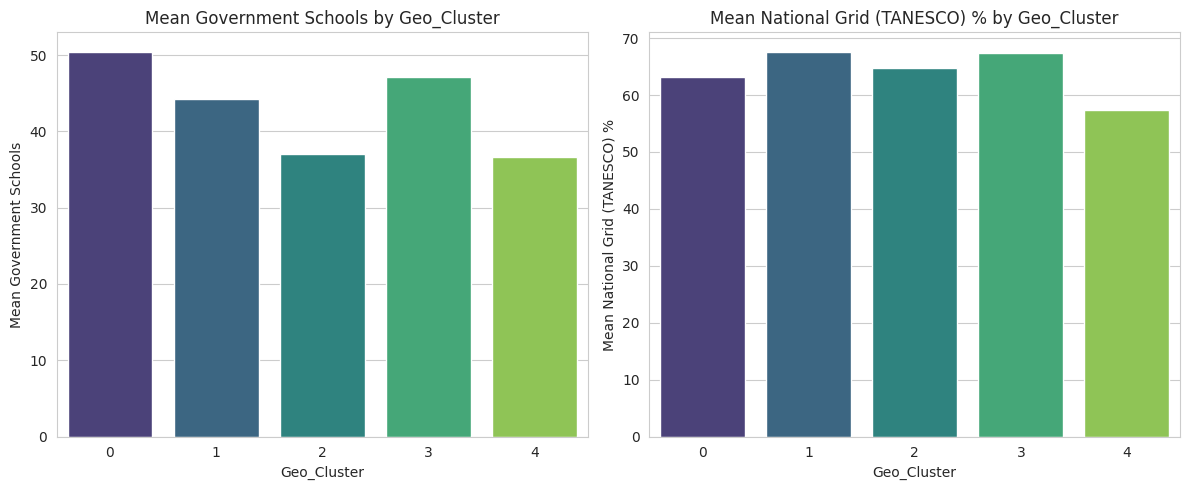


Visualizing distributions (box plots) for selected metrics:


/tmp/ipython-input-3285976628.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Geo_Cluster', y=metric, data=df, ax=axes[i], palette='viridis')
/tmp/ipython-input-3285976628.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Geo_Cluster', y=metric, data=df, ax=axes[i], palette='viridis')


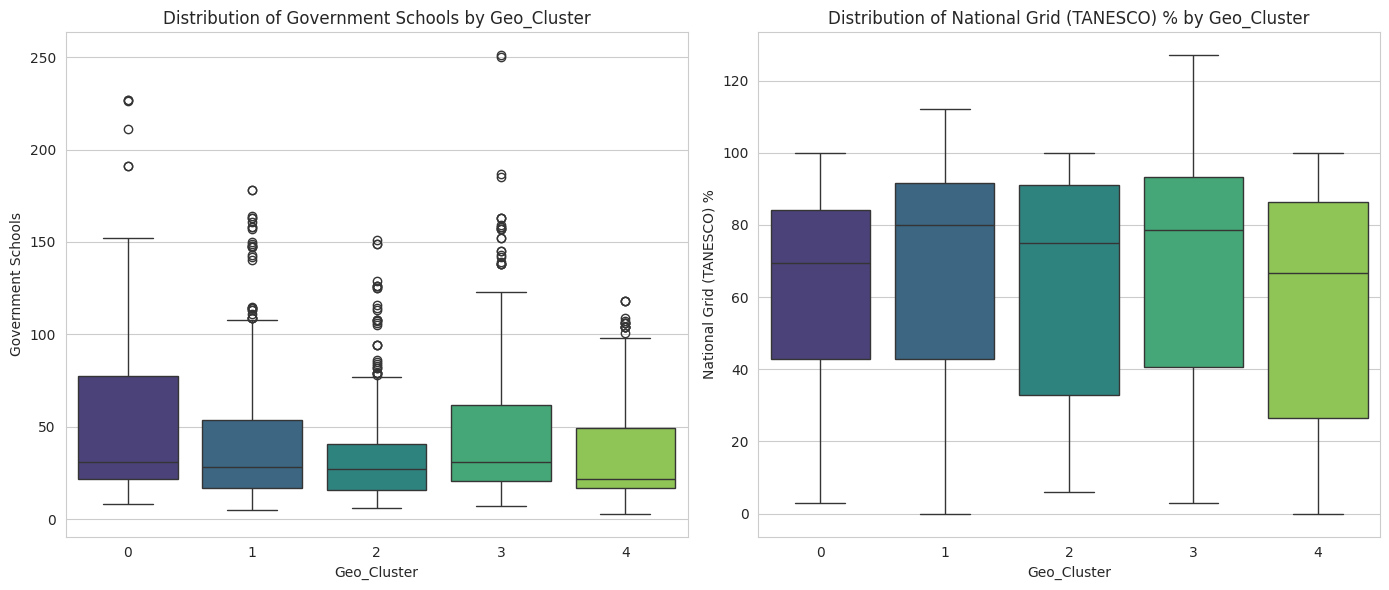

--- All visualizations generated. ---


In [31]:
print("--- Generating Visualizations for Cluster Characteristics ---")

# Set plotting style
sns.set_style("whitegrid")

# Bar plots for mean values from cluster_analysis_results
for df_name, stats_df in cluster_analysis_results.items():
    print(f"\nVisualizing mean metrics for {df_name}:")

    # Get all metric columns from the grouped_stats DataFrame
    # Flatten MultiIndex columns if they exist (mean, median, std)
    if isinstance(stats_df.columns, pd.MultiIndex):
        metrics_to_plot = stats_df.columns.levels[0].tolist()
        # Ensure 'Geo_Cluster' is not treated as a metric if it was somehow included
        if 'Geo_Cluster' in metrics_to_plot:
            metrics_to_plot.remove('Geo_Cluster')
    else:
        metrics_to_plot = stats_df.columns.tolist()

    # Create a figure for each DataFrame to hold multiple bar plots
    n_metrics = len(metrics_to_plot)
    if n_metrics == 0: # Ensure there are metrics to plot
        continue

    fig, axes = plt.subplots(1, n_metrics, figsize=(n_metrics * 6, 5), sharey=False)
    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten() # Flatten in case n_metrics > 1 to iterate easily

    for i, metric in enumerate(metrics_to_plot):
        # Extract mean values for the current metric
        if isinstance(stats_df.columns, pd.MultiIndex):
            plot_data = stats_df[metric]['mean']
        else:
            plot_data = stats_df[metric]

        sns.barplot(x=plot_data.index, y=plot_data.values, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Mean {metric} by Geo_Cluster')
        axes[i].set_xlabel('Geo_Cluster')
        axes[i].set_ylabel(f'Mean {metric}')

    plt.tight_layout()
    plt.show()

# Box plots for distribution from original DataFrames
print("\nVisualizing distributions (box plots) for selected metrics:")
for df_name, metrics in dfs_to_analyze.items():
    df = loaded_dataframes[df_name]

    if 'Geo_Cluster' not in df.columns:
        continue

    valid_metrics = [m for m in metrics if m in df.columns]
    if not valid_metrics:
        continue

    n_metrics = len(valid_metrics)
    if n_metrics == 0:
        continue

    fig, axes = plt.subplots(1, n_metrics, figsize=(n_metrics * 7, 6), sharey=False)
    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten() # Flatten for consistency

    for i, metric in enumerate(valid_metrics):
        sns.boxplot(x='Geo_Cluster', y=metric, data=df, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Distribution of {metric} by Geo_Cluster')
        axes[i].set_xlabel('Geo_Cluster')
        axes[i].set_ylabel(metric)

    plt.tight_layout()
    plt.show()

print("--- All visualizations generated. ---")

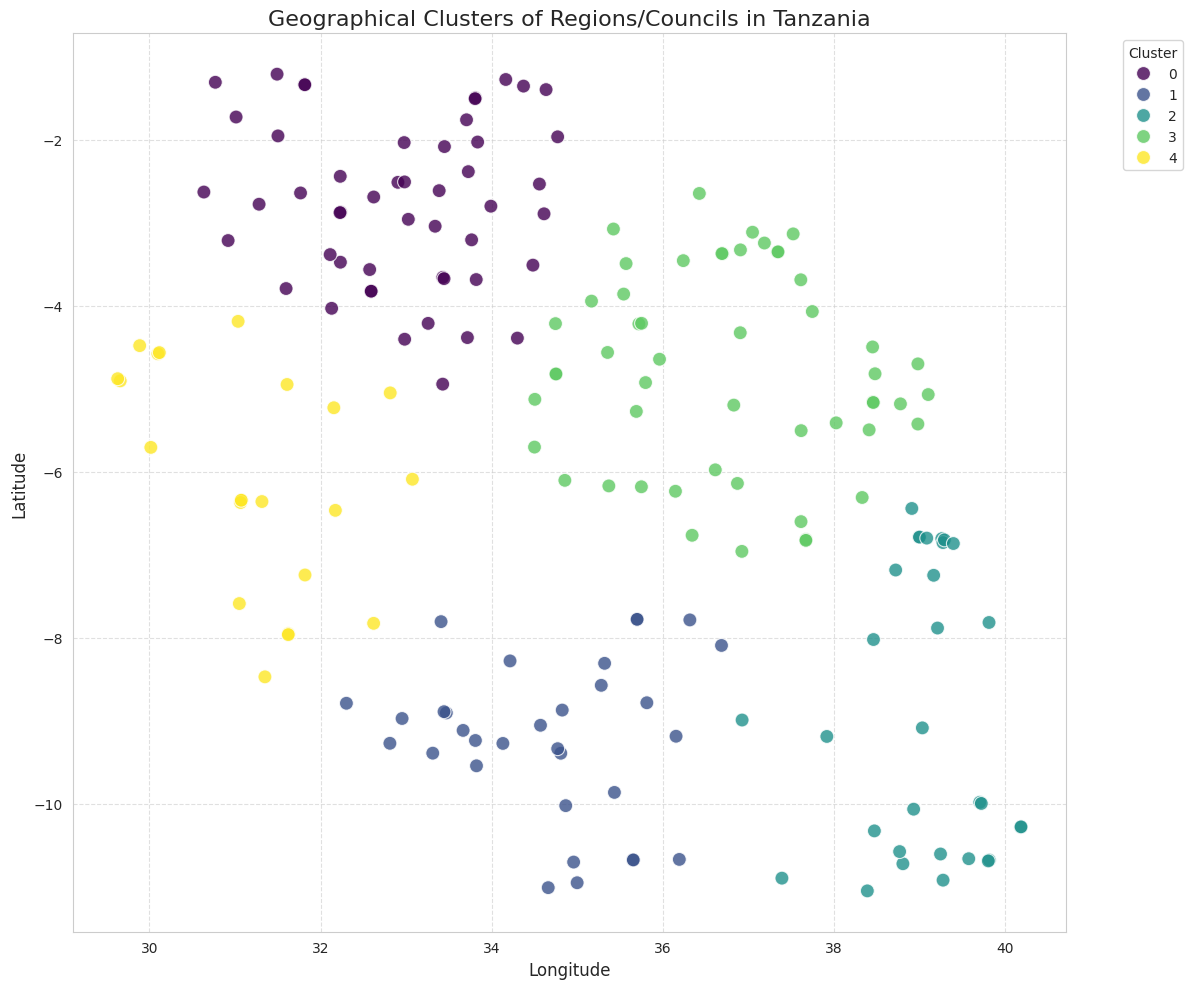

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Latitude and Longitude are numeric and handle any remaining nulls, though it should be clean from previous steps
geo_data['Latitude'] = pd.to_numeric(geo_data['Latitude'], errors='coerce')
geo_data['Longitude'] = pd.to_numeric(geo_data['Longitude'], errors='coerce')
geo_data.dropna(subset=['Latitude', 'Longitude'], inplace=True)

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=geo_data,
    x='Longitude',
    y='Latitude',
    hue='Geo_Cluster',
    palette='viridis',
    s=100, # Adjust point size for better visibility
    alpha=0.8
)

plt.title('Geographical Clusters of Regions/Councils in Tanzania', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [33]:
import folium
from folium.plugins import MarkerCluster
from IPython.display import display

# 1. SETUP MAP
# Centered on Tanzania
tanzania_map = folium.Map(location=[-6.3690, 34.8888], zoom_start=6)
marker_cluster = MarkerCluster().add_to(tanzania_map)

# 2. ADD POINTS
# Assuming 'geo_data_final' is your dataframe with Lat/Lon
for idx, row in geo_data_final.dropna(subset=['Latitude', 'Longitude']).iterrows():
    popup_text = f"{row['Region']} - {row['Council']}"
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_text,
        tooltip=row['Council']
    ).add_to(marker_cluster)

# 3. DISPLAY IN NOTEBOOK
tanzania_map

In [34]:
import numpy as np

# 1. Initialize an empty dictionary
numerical_cols_for_outlier_treatment = {}

# 2. Define a list of columns to exclude from outlier treatment
exclude_cols = ['Year', 'YEAR', 'Academic Year', 'Latitude', 'Longitude', 'Geo_Cluster', 'Geo_Cluster_geo']

# 3. Iterate through each DataFrame
for df_name, df in loaded_dataframes.items():
    # 4. Get a list of all numerical columns
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    # 5. Filter this list to exclude any column whose name is present in the exclude_cols list
    relevant_numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

    # 6. Store the filtered list in the dictionary
    numerical_cols_for_outlier_treatment[df_name] = relevant_numerical_cols

# 7. Print the identified columns
print("Numerical columns identified for outlier treatment:")
for df_name, cols in numerical_cols_for_outlier_treatment.items():
    print(f"  {df_name}: {cols}")

Numerical columns identified for outlier treatment:
  Dropout-Secondary  2017-2024: ['Death', 'Indiscipline', 'Pregnancy', 'Truancy']
  Data-Secondary Tables and chairs 2016-2025: ['Enrollment', 'Available_tables', 'Available_chairs']
  Secondary-Re_entry: ['Re-Enrolled Students, Form 1 Boys', 'Re-Enrolled Students, Form 1 Girls', 'Re-Enrolled Students, Form 2 Boys', 'Re-Enrolled Students, Form 2 Girls', 'Re-Enrolled Students, Form 3 Boys', 'Re-Enrolled Students, Form 3 Girls', 'Re-Enrolled Students, Form 4 Boys', 'Re-Enrolled Students, Form 4 Girls', 'Re-Enrolled Students, Form 5 Boys', 'Re-Enrolled Students, Form 5 Girls', 'Re-Enrolled Students, Form 6 Boys', 'Re-Enrolled Students, Form 6 Girls']
  Secondary - DISABALITY 2020-2025: ['Blind', 'Low Vision']
  Combined_Secondary_Laboratories_Govt: ['BIOLOGY LABORATORY NEEDED', 'BIOLOGY LABORATORY AVAILABLE', 'BIOLOGY LABORATORY SHORTAGE', 'CHEMISTRY LABORATORY NEEDED', 'CHEMISTRY LABORATORY AVAILABLE', 'CHEMISTRY LABORATORY SHORTAGE', '

In [35]:
import pandas as pd

print("--- Listing all DataFrames with columns and data types ---")

for df_name, df in loaded_dataframes.items():
    print(f"\n--- DataFrame: {df_name} ---")
    df.info()

--- Listing all DataFrames with columns and data types ---

--- DataFrame: Dropout-Secondary  2017-2024 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          1416 non-null   int64 
 1   REGION        1416 non-null   object
 2   COUNCIL       1416 non-null   object
 3   Death         1416 non-null   int64 
 4   Indiscipline  1416 non-null   int64 
 5   Pregnancy     1416 non-null   int64 
 6   Truancy       1416 non-null   int64 
 7   Region        1416 non-null   object
 8   Council       1416 non-null   object
 9   LGA_Status    1416 non-null   object
 10  Geo_Cluster   1416 non-null   int32 
dtypes: int32(1), int64(5), object(5)
memory usage: 116.3+ KB

--- DataFrame: Data-Secondary Tables and chairs 2016-2025 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 10 columns):
 #   Co

In [38]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import re

# ==========================================
# 1. Data Cleaning & Standardization
# ==========================================
def standard_cols(df):
    """Standardizes column names to Upper Case and strips whitespace."""
    df = df.copy()
    # Convert to string first to handle potential non-string headers
    df.columns = [str(c).strip().upper() for c in df.columns]

    # Standardize common location columns
    rename_map = {
        'YEAR': 'YEAR', 'REGION': 'REGION', 'COUNCIL': 'COUNCIL',
        'LGA_STATUS': 'LGA_STATUS', 'GEO_CLUSTER': 'GEO_CLUSTER'
    }
    df.rename(columns=rename_map, inplace=True)

    # Drop duplicates
    df = df.loc[:, ~df.columns.duplicated()]
    return df

def prepare_secondary_datasets(df_subject_enroll, df_drop, df_table, df_reentry, df_disability, df_ict, df_elec, df_labs):
    """
    Cleans and prepares the Subject-Level enrollment data.
    """
    # Standardize all inputs
    enroll = standard_cols(df_subject_enroll)
    drops = standard_cols(df_drop)
    tables = standard_cols(df_table)
    reentry = standard_cols(df_reentry)
    disability = standard_cols(df_disability)
    ict = standard_cols(df_ict)
    elec = standard_cols(df_elec)
    labs = standard_cols(df_labs)

    # --- 1. Reshape Subject Enrollment (Wide to Long) ---
    # Identify ID columns
    id_vars = ['YEAR', 'REGION', 'COUNCIL']
    available_ids = [c for c in id_vars if c in enroll.columns]

    # Identify Subject Columns (Those starting with 'FORM')
    # Example format after standard_cols: "FORM 1 STUDENTS - PHYSICS_GENERAL"
    subject_cols = [c for c in enroll.columns if 'FORM ' in c and ' - ' in c]

    print(f"Detected {len(subject_cols)} subject columns to melt.")

    # Melt to Long Format
    enroll_long = enroll.melt(id_vars=available_ids,
                              value_vars=subject_cols,
                              var_name='RAW_COL',
                              value_name='ENROLLMENT')

    # --- 2. Extract Metadata from Column Headers ---
    # Extract Form Number (e.g., "FORM 1" -> 1)
    enroll_long['FORM_NUM'] = enroll_long['RAW_COL'].str.extract(r'FORM (\d)').astype(int)

    # Extract Subject Name (e.g., "PHYSICS_GENERAL")
    # We split by " - " and take the second part
    enroll_long['SUBJECT'] = enroll_long['RAW_COL'].str.split(' - ').str[1].str.strip()

    # Drop the raw column to save memory
    enroll_long.drop(columns=['RAW_COL'], inplace=True)

    # --- 3. Aggregations for Feature Sets (Same as before) ---
    # Note: These are Council-level features, they will apply to ALL subjects in that council
    keys = ['YEAR', 'REGION', 'COUNCIL']

    # Re-entry
    re_cols = [c for c in reentry.columns if 'RE-ENROLLED' in c]
    if re_cols:
        reentry['TOTAL_REENTRY'] = reentry[re_cols].sum(axis=1)
        reentry_clean = reentry[keys + ['TOTAL_REENTRY']].groupby(keys).sum().reset_index()
    else:
        reentry_clean = pd.DataFrame(columns=keys + ['TOTAL_REENTRY'])

    # Disability
    dis_cols = ['BLIND', 'LOW VISION']
    avail_dis = [c for c in dis_cols if c in disability.columns]
    if avail_dis:
        disability['TOTAL_DISABLED'] = disability[avail_dis].sum(axis=1)
        dis_clean = disability[keys + ['TOTAL_DISABLED']].groupby(keys).sum().reset_index()
    else:
        dis_clean = pd.DataFrame(columns=keys + ['TOTAL_DISABLED'])

    # Tables
    if 'AVAILABLE_TABLES' in tables.columns:
        tables_clean = tables[keys + ['AVAILABLE_TABLES']].copy()
    else:
        tables_clean = pd.DataFrame(columns=keys + ['AVAILABLE_TABLES'])

    # ICT
    if 'DESKTOP COMPUTERS' in ict.columns and 'LAPTOP COMPUTERS' in ict.columns:
        ict['TOTAL_COMPUTERS'] = ict['DESKTOP COMPUTERS'].fillna(0) + ict['LAPTOP COMPUTERS'].fillna(0)
        ict_clean = ict[keys + ['TOTAL_COMPUTERS']].copy()
    else:
        ict_clean = pd.DataFrame(columns=keys + ['TOTAL_COMPUTERS'])

    # Electricity
    elec_col = 'NATIONAL GRID (TANESCO) %'
    if elec_col in elec.columns:
        elec_clean = elec[keys + [elec_col]].copy()
        elec_clean.rename(columns={elec_col: 'ELEC_GRID_PCT'}, inplace=True)
    else:
        elec_clean = pd.DataFrame(columns=keys + ['ELEC_GRID_PCT'])

    # Labs (Specific Logic for Subject Relevance)
    # We create a Total Labs metric, but advanced versions could map Physics enrollment to Physics labs
    lab_types = ['BIOLOGY', 'CHEMISTRY', 'PHYSICS']
    lab_cols = [f'{l} LABORATORY AVAILABLE' for l in lab_types]
    valid_labs = [c for c in lab_cols if c in labs.columns]
    if valid_labs:
        labs['TOTAL_LABS'] = labs[valid_labs].sum(axis=1)
        labs_clean = labs[keys + ['TOTAL_LABS']].copy()
    else:
        labs_clean = pd.DataFrame(columns=keys + ['TOTAL_LABS'])

    return enroll_long, drops, tables_clean, reentry_clean, dis_clean, ict_clean, elec_clean, labs_clean

# ==========================================
# 2. Feature Engineering (Subject-Aware)
# ==========================================
def engineer_secondary_features(df, drops, tables, reentry, disability, ict, elec, labs):
    keys = ['YEAR', 'REGION', 'COUNCIL']

    # --- Merge Infrastructure (Council Level) ---
    # This broadcasts council-level stats (like electricity) to every subject row in that council
    df = df.merge(tables, on=keys, how='left').fillna({'AVAILABLE_TABLES': 0})
    df = df.merge(reentry, on=keys, how='left').fillna({'TOTAL_REENTRY': 0})
    df = df.merge(disability, on=keys, how='left').fillna({'TOTAL_DISABLED': 0})
    df = df.merge(ict, on=keys, how='left').fillna({'TOTAL_COMPUTERS': 0})
    df = df.merge(elec, on=keys, how='left').fillna({'ELEC_GRID_PCT': 0})
    df = df.merge(labs, on=keys, how='left').fillna({'TOTAL_LABS': 0})

    # Dropouts (Sum causes)
    drop_cols = ['TRUANCY', 'PREGNANCY', 'INDISCIPLINE']
    valid_drops = [c for c in drop_cols if c in drops.columns]
    if valid_drops:
        d_grp = drops.groupby(keys)[valid_drops].sum().reset_index()
        df = df.merge(d_grp, on=keys, how='left').fillna(0)

    # Sort for Time Series Ops
    # Crucial: Must sort by Subject as well to ensure lags calculate correctly
    df = df.sort_values(['REGION', 'COUNCIL', 'SUBJECT', 'FORM_NUM', 'YEAR'])

    # --- Temporal Features ---
    df['IS_ELECTION_YEAR'] = df['YEAR'].apply(lambda x: 1 if x in [2015, 2020, 2025] else 0)

    # --- Subject-Specific Lags & Trends ---
    # We now group by SUBJECT as well.
    # Logic: How did Physics enrollment in this specific council grow over time?
    g = df.groupby(['REGION', 'COUNCIL', 'SUBJECT', 'FORM_NUM'])

    df['LAG_1'] = g['ENROLLMENT'].shift(1)
    df['LAG_2'] = g['ENROLLMENT'].shift(2)
    df['YOY_GROWTH'] = (df['ENROLLMENT'] - df['LAG_1']) / (df['LAG_1'] + 1e-5)

    # --- Subject-Specific Cohort Logic ---
    # Logic: Form 1 Physics (Year T) -> Form 2 Physics (Year T+1)

    df['PREV_YEAR'] = df['YEAR'] - 1
    df['PREV_FORM_NUM'] = df['FORM_NUM'] - 1

    # Join Key includes SUBJECT now
    df['LOOKUP_KEY'] = (
        df['YEAR'].astype(str) + '_' +
        df['REGION'] + '_' +
        df['COUNCIL'] + '_' +
        df['SUBJECT'] + '_' +  # <--- Added Subject
        df['FORM_NUM'].astype(str)
    )

    # Create lookup dict: Key -> Enrollment
    # Deduplicate first just in case (summing enrollment if duplicates exist)
    lookup_df = df.groupby('LOOKUP_KEY')['ENROLLMENT'].sum()
    enrollment_lookup = lookup_df.to_dict()

    # Generate the Key to look for (Previous Year, Previous Form, Same Subject)
    df['COHORT_LOOKUP_KEY'] = (
        df['PREV_YEAR'].astype(str) + '_' +
        df['REGION'] + '_' +
        df['COUNCIL'] + '_' +
        df['SUBJECT'] + '_' + # <--- Added Subject
        df['PREV_FORM_NUM'].astype(str)
    )

    # Map values
    df['COHORT_LAG'] = df['COHORT_LOOKUP_KEY'].map(enrollment_lookup)

    # Fill N/A (Entry grades or missing history) with -1
    df['COHORT_LAG'] = df['COHORT_LAG'].fillna(-1)

    # Cleanup aux columns
    df.drop(columns=['PREV_YEAR', 'PREV_FORM_NUM', 'LOOKUP_KEY', 'COHORT_LOOKUP_KEY'], inplace=True)
    df = df.fillna(-1)

    return df

# ==========================================
# 3. Model Training (Updated for Subject)
# ==========================================
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    print(f"--- {model_name} Results ---")
    print(f"MAE  : {mae:,.2f}")
    print(f"RMSE : {rmse:,.2f}")
    print(f"R^2  : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print("-" * 30)
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

def train_secondary_models(df):
    le = LabelEncoder()
    # Encode Categoricals
    df['REGION_ENC'] = le.fit_transform(df['REGION'].astype(str))
    df['COUNCIL_ENC'] = le.fit_transform(df['COUNCIL'].astype(str))
    # NEW: Encode Subject
    df['SUBJECT_ENC'] = le.fit_transform(df['SUBJECT'].astype(str))

    features = [
        'YEAR', 'REGION_ENC', 'COUNCIL_ENC', 'SUBJECT_ENC', 'FORM_NUM',
        'AVAILABLE_TABLES', 'TOTAL_REENTRY', 'TOTAL_DISABLED',
        'TOTAL_COMPUTERS', 'ELEC_GRID_PCT', 'TOTAL_LABS',
        'TRUANCY', 'PREGNANCY', 'INDISCIPLINE',
        'LAG_1', 'LAG_2', 'YOY_GROWTH', 'COHORT_LAG', 'IS_ELECTION_YEAR'
    ]

    features = [f for f in features if f in df.columns]

    # Split Train/Test (Subject data usually requires a recent split)
    train = df[df['YEAR'] < 2024]
    test = df[df['YEAR'] >= 2024]

    X_train, y_train = train[features], train['ENROLLMENT']
    X_test, y_test = test[features], test['ENROLLMENT']

    print(f"Training on {X_train.shape[0]} rows (Subjects x Locations), Testing on {X_test.shape[0]} rows.")

    results = {}

    # XGBoost
    xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=9, learning_rate=0.05, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    results['XGB'] = calculate_metrics(y_test, xgb_model.predict(X_test), "XGBoost")

    # LightGBM
    lgb_model = lgb.LGBMRegressor(n_estimators=150, num_leaves=40, verbose=-1)
    lgb_model.fit(X_train, y_train)
    results['LGBM'] = calculate_metrics(y_test, lgb_model.predict(X_test), "LightGBM")

    return results, xgb_model

# ==========================================
# 4. Pipeline Execution
# ==========================================
def run_secondary_pipeline(df_subject, drop_df, table_df, reentry_df, dis_df, ict_df, elec_df, labs_df):
    print("1. Preparing Subject Datasets...")
    enroll, drops, tables, reentry, dis, ict, elec, labs = prepare_secondary_datasets(
        df_subject, drop_df, table_df, reentry_df, dis_df, ict_df, elec_df, labs_df
    )

    print("2. Engineering Features (Subject Cohorts)...")
    final_df = engineer_secondary_features(enroll, drops, tables, reentry, dis, ict, elec, labs)

    print("\n==========================================")
    print(" SUBJECT-LEVEL ENROLLMENT FORECASTING ")
    print("==========================================")
    metrics, model = train_secondary_models(final_df)

    return final_df, metrics, model

# EXECUTION
# Ensure your dataframe names match exactly what is loaded in your environment
secondary_final_df, sec_metrics, sec_model = run_secondary_pipeline(
    loaded_dataframes["Secondary_students_per_subject"], # <--- The new subject dataframe
    loaded_dataframes["Dropout-Secondary  2017-2024"],
    loaded_dataframes["Data-Secondary Tables and chairs 2016-2025"],
    loaded_dataframes["Secondary-Re_entry"],
    loaded_dataframes["Secondary - DISABALITY 2020-2025"],
    loaded_dataframes["Combined_Secondary_ICT_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Electricity_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Laboratories_All_G_NG"]
)

1. Preparing Subject Datasets...
Detected 283 subject columns to melt.
2. Engineering Features (Subject Cohorts)...

 SUBJECT-LEVEL ENROLLMENT FORECASTING 
Training on 415444 rows (Subjects x Locations), Testing on 104144 rows.
--- XGBoost Results ---
MAE  : 29.95
RMSE : 331.21
R^2  : 0.9639
MAPE : 6.77%
------------------------------
--- LightGBM Results ---
MAE  : 26.68
RMSE : 301.34
R^2  : 0.9702
MAPE : 9.95%
------------------------------


In [39]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================
# 1. Data Prep & Feature Engineering (Subject-Aware)
# ==========================================
def prepare_subject_data(df_subject, df_drop, df_table, df_reentry, df_disability, df_ict, df_elec, df_labs):
    # Standardize Column Names
    def clean_cols(d):
        d = d.copy()
        d.columns = [str(c).strip().upper() for c in d.columns]
        rename_map = {'YEAR': 'YEAR', 'REGION': 'REGION', 'COUNCIL': 'COUNCIL'}
        d.rename(columns=rename_map, inplace=True)
        return d.loc[:, ~d.columns.duplicated()]

    enroll = clean_cols(df_subject)
    tables = clean_cols(df_table)
    reentry = clean_cols(df_reentry)
    disability = clean_cols(df_disability)
    ict = clean_cols(df_ict)
    elec = clean_cols(df_elec)
    labs = clean_cols(df_labs)

    # --- Melt to Long Format (Subject Level) ---
    id_vars = ['YEAR', 'REGION', 'COUNCIL']
    # Filter only available ID vars
    id_vars = [c for c in id_vars if c in enroll.columns]

    subject_cols = [c for c in enroll.columns if 'FORM ' in c and ' - ' in c]

    print(f"Melting {len(subject_cols)} subject columns...")
    long_df = enroll.melt(id_vars=id_vars, value_vars=subject_cols, var_name='RAW', value_name='ENROLLMENT')

    # Extract Metadata
    long_df['FORM_NUM'] = long_df['RAW'].str.extract(r'FORM (\d)').astype(int)
    long_df['SUBJECT'] = long_df['RAW'].str.split(' - ').str[1].str.strip()
    long_df.drop(columns=['RAW'], inplace=True)

    # --- Merge Council Features ---
    # (Broadcasting council stats to all subjects in that council)
    keys = ['YEAR', 'REGION', 'COUNCIL']

    # Simple aggregates for merging
    if 'AVAILABLE_TABLES' in tables.columns:
        long_df = long_df.merge(tables[keys + ['AVAILABLE_TABLES']], on=keys, how='left').fillna(0)
    else:
        long_df['AVAILABLE_TABLES'] = 0

    # Labs (Total)
    lab_cols = [c for c in labs.columns if 'LABORATORY' in c]
    if lab_cols:
        labs['TOTAL_LABS'] = labs[lab_cols].sum(axis=1)
        long_df = long_df.merge(labs[keys + ['TOTAL_LABS']], on=keys, how='left').fillna(0)
    else:
        long_df['TOTAL_LABS'] = 0

    # Sort for calculations
    long_df = long_df.sort_values(['REGION', 'COUNCIL', 'SUBJECT', 'FORM_NUM', 'YEAR'])

    # --- Generate History (Lags) ---
    g = long_df.groupby(['REGION', 'COUNCIL', 'SUBJECT', 'FORM_NUM'])
    long_df['LAG_1'] = g['ENROLLMENT'].shift(1)
    long_df['LAG_2'] = g['ENROLLMENT'].shift(2)
    long_df['YOY_GROWTH'] = (long_df['ENROLLMENT'] - long_df['LAG_1']) / (long_df['LAG_1'] + 1e-5)

    # --- Generate Cohort Flow (Subject Specific) ---
    # Form 3 Physics (Year T) needs Form 2 Physics (Year T-1)
    long_df['PREV_YEAR'] = long_df['YEAR'] - 1
    long_df['PREV_FORM'] = long_df['FORM_NUM'] - 1

    # Create Lookup Key
    long_df['LOOKUP_KEY'] = (long_df['YEAR'].astype(str) + '_' + long_df['REGION'] + '_' +
                             long_df['COUNCIL'] + '_' + long_df['SUBJECT'] + '_' + long_df['FORM_NUM'].astype(str))

    lookup = long_df.groupby('LOOKUP_KEY')['ENROLLMENT'].sum().to_dict()

    # Generate Search Key
    long_df['SEARCH_KEY'] = (long_df['PREV_YEAR'].astype(str) + '_' + long_df['REGION'] + '_' +
                             long_df['COUNCIL'] + '_' + long_df['SUBJECT'] + '_' + long_df['PREV_FORM'].astype(str))

    long_df['COHORT_LAG'] = long_df['SEARCH_KEY'].map(lookup).fillna(-1)

    # Clean up
    long_df.drop(columns=['PREV_YEAR', 'PREV_FORM', 'LOOKUP_KEY', 'SEARCH_KEY'], inplace=True)
    long_df['IS_ELECTION_YEAR'] = long_df['YEAR'].isin([2020, 2025, 2030]).astype(int)

    return long_df.fillna(-1)

# ==========================================
# 2. Recursive Forecast Helper (Subject Specific)
# ==========================================
def create_next_year_subject_features(last_year_df, current_year):
    """
    Generates features for Year T based on Year T-1 data for SUBJECTS.
    """
    next_df = last_year_df.copy()
    next_df['YEAR'] = current_year

    # 1. Shift Lags
    next_df['LAG_2'] = next_df['LAG_1']
    next_df['LAG_1'] = next_df['ENROLLMENT'] # The prediction from previous loop becomes history

    # 2. Update Growth (Capped)
    next_df['YOY_GROWTH'] = (next_df['LAG_1'] - next_df['LAG_2']) / (next_df['LAG_2'] + 1e-5)

    # 3. Update Cohort Lag (Subject Specific)
    # We need a dictionary of the T-1 data we just finished processing
    # Key: (Region, Council, Subject, Form) -> Value: Enrollment
    cohort_lookup = last_year_df.set_index(['REGION', 'COUNCIL', 'SUBJECT', 'FORM_NUM'])['ENROLLMENT'].to_dict()

    def get_cohort(row):
        target_form = row['FORM_NUM'] - 1
        if target_form < 1: return -1 # Form 1 has no previous form

        # Look for the SAME Subject in the PREVIOUS Form
        key = (row['REGION'], row['COUNCIL'], row['SUBJECT'], target_form)
        return cohort_lookup.get(key, -1)

    next_df['COHORT_LAG'] = next_df.apply(get_cohort, axis=1)

    # 4. Static/Time Features
    next_df['IS_ELECTION_YEAR'] = 1 if current_year in [2025, 2030] else 0
    next_df['ENROLLMENT'] = np.nan # Reset target

    return next_df

# ==========================================
# 3. Main Training & Forecasting Pipeline
# ==========================================
def run_subject_forecast_system(df_subject, df_drop, df_table, df_reentry, df_disability, df_ict, df_elec, df_labs):

    print("STEP 1: Preparing Subject Data...")
    df = prepare_subject_data(df_subject, df_drop, df_table, df_reentry, df_disability, df_ict, df_elec, df_labs)

    # Encoders
    le_reg = LabelEncoder()
    le_cou = LabelEncoder()
    le_sub = LabelEncoder() # <--- New Subject Encoder

    df['REGION_ENC'] = le_reg.fit_transform(df['REGION'].astype(str))
    df['COUNCIL_ENC'] = le_cou.fit_transform(df['COUNCIL'].astype(str))
    df['SUBJECT_ENC'] = le_sub.fit_transform(df['SUBJECT'].astype(str))

    # Features
    feats = [
        'YEAR', 'REGION_ENC', 'COUNCIL_ENC', 'SUBJECT_ENC', 'FORM_NUM',
        'AVAILABLE_TABLES', 'TOTAL_LABS', 'LAG_1', 'LAG_2',
        'YOY_GROWTH', 'COHORT_LAG', 'IS_ELECTION_YEAR'
    ]

    # Train on History (Up to 2025)
    train_df = df[df['YEAR'] <= 2025].copy()
    X = train_df[feats]
    y = train_df['ENROLLMENT']

    print(f"STEP 2: Training Models on {len(train_df)} rows...")

    # XGBoost
    model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=8, learning_rate=0.05, n_jobs=-1)
    model_xgb.fit(X, y)

    # LightGBM
    model_lgb = lgb.LGBMRegressor(n_estimators=200, num_leaves=60, verbose=-1)
    model_lgb.fit(X, y)

    print("STEP 3: Recursive Forecasting (2026-2030)...")
    future_preds = []

    # Start with 2025 data as the "Previous Year"
    current_sim = df[df['YEAR'] == 2025].copy()

    for year in range(2026, 2031):
        # Generate Features for Next Year
        next_step = create_next_year_subject_features(current_sim, year)

        # Predict
        X_future = next_step[feats]
        pred_xgb = model_xgb.predict(X_future)
        pred_lgb = model_lgb.predict(X_future)

        # Average Ensemble & Safety Clip
        next_step['ENROLLMENT'] = (pred_xgb + pred_lgb) / 2
        next_step['ENROLLMENT'] = next_step['ENROLLMENT'].apply(lambda x: max(0, x))

        future_preds.append(next_step)

        # Update simulation for next loop
        current_sim = next_step.copy()
        print(f" > {year} Forecast Complete.")

    # Compile Results
    forecast_df = pd.concat(future_preds, ignore_index=True)

    # Select clean output columns
    output_cols = ['YEAR', 'REGION', 'COUNCIL', 'SUBJECT', 'FORM_NUM', 'ENROLLMENT']
    final_output = forecast_df[output_cols].copy()
    final_output['ENROLLMENT'] = final_output['ENROLLMENT'].round(0).astype(int)

    return final_output

# ==========================================
# EXECUTION
# ==========================================
subject_forecast_results = run_subject_forecast_system(
    loaded_dataframes["Secondary_students_per_subject"], # <--- Your Subject DataFrame
    loaded_dataframes["Dropout-Secondary  2017-2024"],
    loaded_dataframes["Data-Secondary Tables and chairs 2016-2025"],
    loaded_dataframes["Secondary-Re_entry"],
    loaded_dataframes["Secondary - DISABALITY 2020-2025"],
    loaded_dataframes["Combined_Secondary_ICT_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Electricity_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Laboratories_All_G_NG"]
)

print("\n--- Sample Subject Forecast (2026-2030) ---")
print(subject_forecast_results.head())

STEP 1: Preparing Subject Data...
Melting 283 subject columns...
STEP 2: Training Models on 519588 rows...
STEP 3: Recursive Forecasting (2026-2030)...
 > 2026 Forecast Complete.
 > 2027 Forecast Complete.
 > 2028 Forecast Complete.
 > 2029 Forecast Complete.
 > 2030 Forecast Complete.

--- Sample Subject Forecast (2026-2030) ---
   YEAR  REGION COUNCIL                         SUBJECT  FORM_NUM  ENROLLMENT
0  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         1           0
1  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         2           0
2  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         3           0
3  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         4           0
4  2026  ARUSHA  ARUSHA  ADDITIONAL MATHEMATICS_GENERAL         1           0


/tmp/ipython-input-376558549.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.1f}M'.format(x/1e6) for x in current_values])


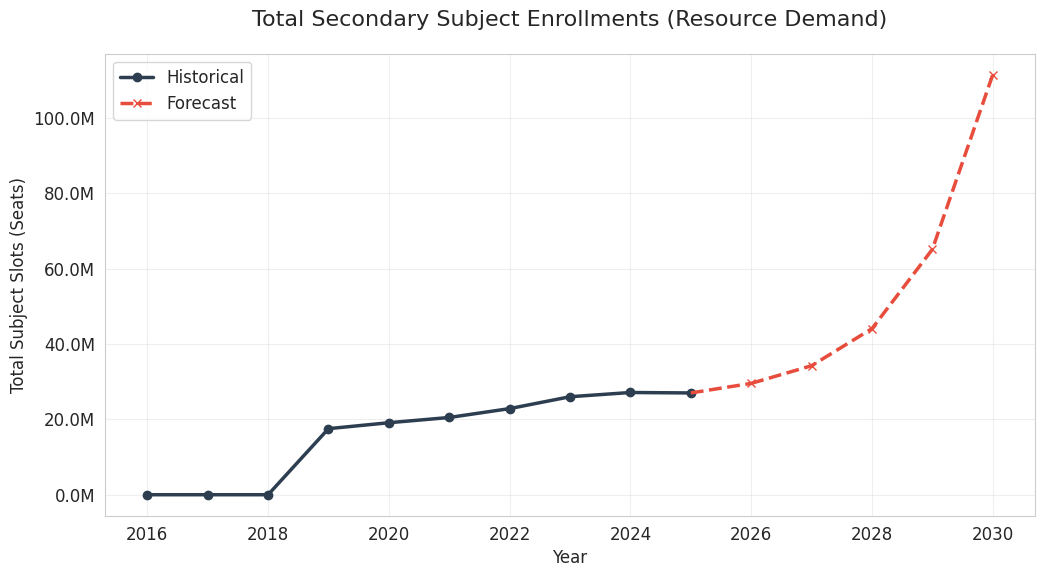

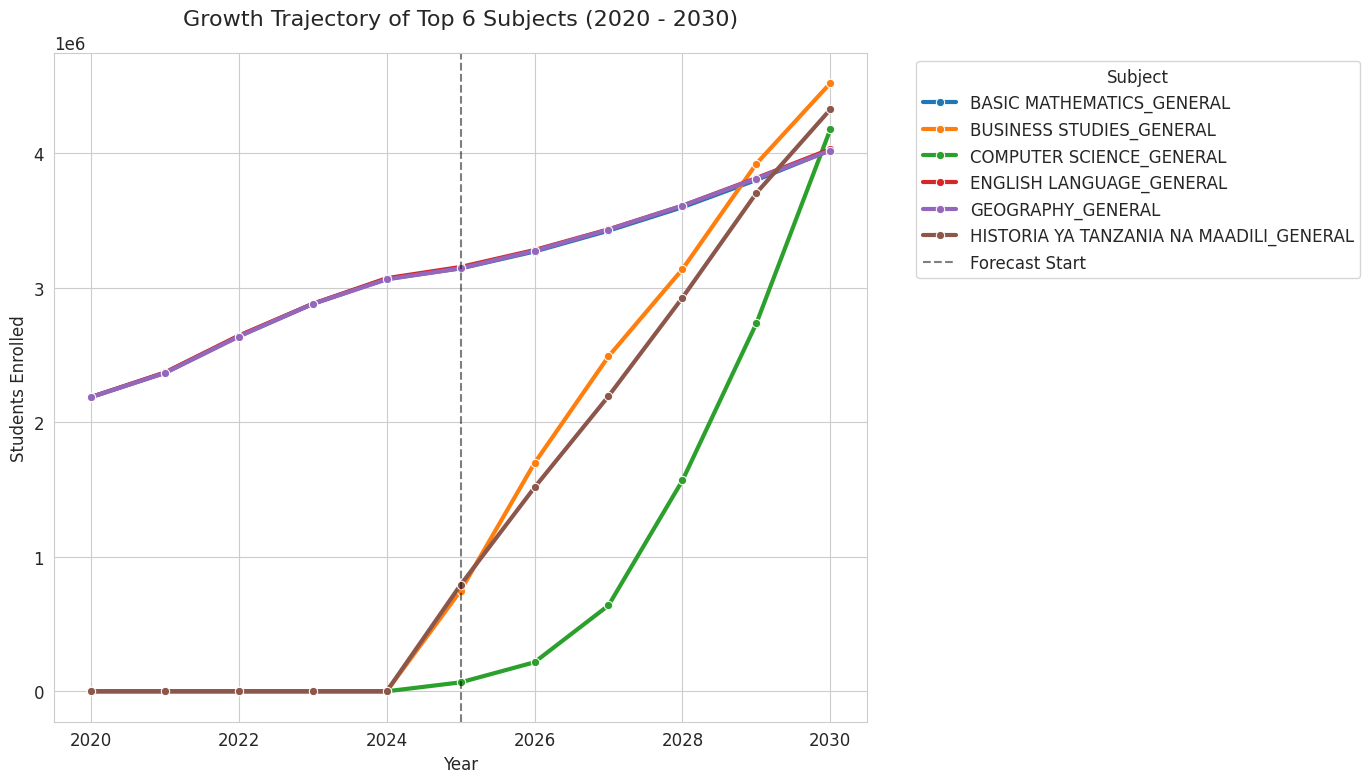

<Figure size 1200x700 with 0 Axes>

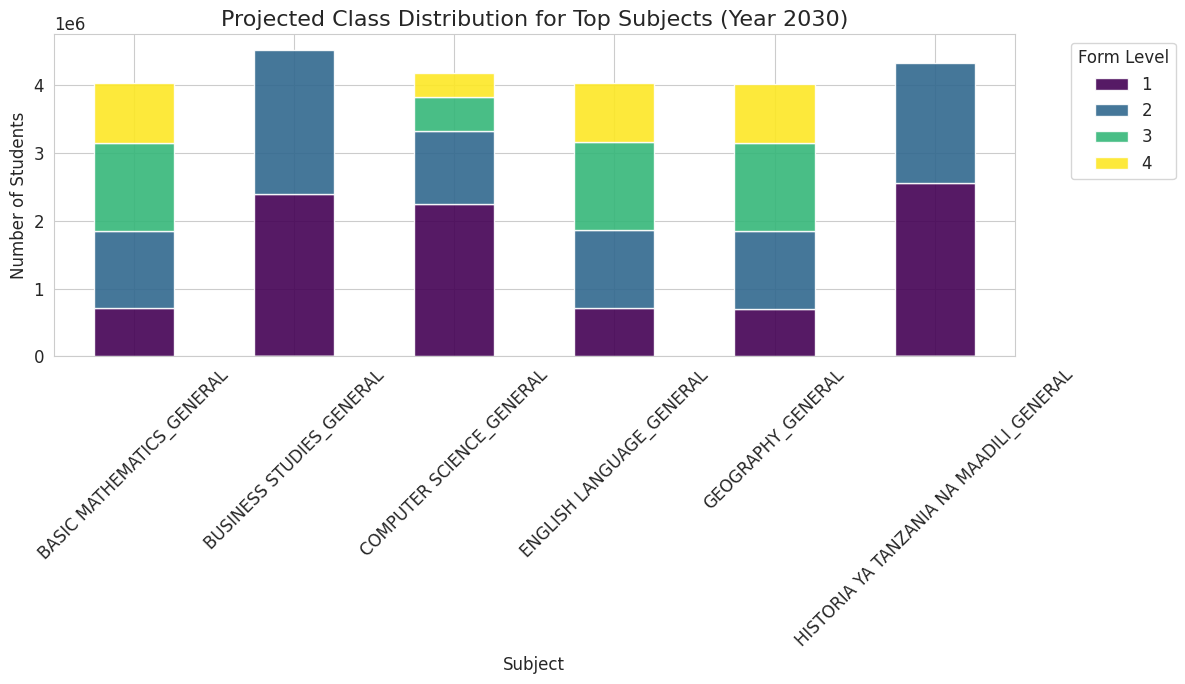

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_subject_forecasts(history_df, forecast_df):
    """
    Plots historical vs. forecasted trends specifically for Secondary School SUBJECTS.
    Args:
        history_df: DataFrame of historical Subject data (2016-2025)
        forecast_df: DataFrame of forecasted Subject data (2026-2030)
    """
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 12})

    # --- 1. PREPARE DATA ---
    # Select only necessary columns to avoid merge conflicts
    req_cols = ['YEAR', 'ENROLLMENT', 'SUBJECT', 'FORM_NUM', 'REGION']

    # Standardize and Label
    hist_clean = history_df[req_cols].copy()
    hist_clean['Type'] = 'Historical'

    forc_clean = forecast_df[req_cols].copy()
    forc_clean['Type'] = 'Forecast'

    # Combine into one Master DataFrame
    full_data = pd.concat([hist_clean, forc_clean])

    # --- CHART 1: Total "Subject Slots" Trajectory ---
    # NOTE: This sums every subject taken. One student takes ~7-10 subjects.
    # This chart represents "Total Textbooks/Seats needed," not "Total Students."
    plt.figure(figsize=(12, 6))

    total_trend = full_data.groupby(['YEAR', 'Type'])['ENROLLMENT'].sum().reset_index()

    # Plot History
    hist_trend = total_trend[total_trend['Type'] == 'Historical']
    plt.plot(hist_trend['YEAR'], hist_trend['ENROLLMENT'],
             label='Historical', color='#2c3e50', linewidth=2.5, marker='o')

    # Plot Forecast
    forc_trend = total_trend[total_trend['Type'] == 'Forecast']
    plt.plot(forc_trend['YEAR'], forc_trend['ENROLLMENT'],
             label='Forecast', color='#e74c3c', linewidth=2.5, linestyle='--', marker='x')

    # Connect the visual gap (2025 -> 2026)
    if not hist_trend.empty and not forc_trend.empty:
        connect_x = [hist_trend['YEAR'].max(), forc_trend['YEAR'].min()]
        connect_y = [hist_trend['ENROLLMENT'].iloc[-1], forc_trend['ENROLLMENT'].iloc[0]]
        plt.plot(connect_x, connect_y, color='#e74c3c', linestyle='--', linewidth=2.5)

    plt.title('Total Secondary Subject Enrollments (Resource Demand)', fontsize=16, pad=20)
    plt.ylabel('Total Subject Slots (Seats)', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Format Y-axis to Millions (e.g., 5.0M)
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.1f}M'.format(x/1e6) for x in current_values])
    plt.show()

    # --- CHART 2: Growth Trends of Top 6 Subjects (The "Science vs Arts" View) ---
    plt.figure(figsize=(14, 8))

    # 1. Identify the Top 6 Subjects by volume in 2030 (Predicted)
    top_subs_2030 = full_data[full_data['YEAR'] == 2030].groupby('SUBJECT')['ENROLLMENT'].sum()
    top_subs_names = top_subs_2030.sort_values(ascending=False).head(6).index.tolist()

    # 2. Filter data for these subjects (Show 2020-2030 for clarity)
    sub_data = full_data[
        (full_data['SUBJECT'].isin(top_subs_names)) &
        (full_data['YEAR'] >= 2020)
    ]

    # 3. Aggregate
    sub_trend = sub_data.groupby(['YEAR', 'SUBJECT'])['ENROLLMENT'].sum().reset_index()

    # 4. Plot Lines
    sns.lineplot(data=sub_trend, x='YEAR', y='ENROLLMENT', hue='SUBJECT',
                 linewidth=3, palette='tab10', marker='o')

    plt.title('Growth Trajectory of Top 6 Subjects (2020 - 2030)', fontsize=16, pad=20)
    plt.ylabel('Students Enrolled', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.axvline(x=2025, color='black', linestyle='--', alpha=0.5, label='Forecast Start')
    plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- CHART 3: Subject Enrollment by Form Level (Stacked Bar) ---
    # This answers: "Are most Physics students in Form 1 or Form 4?"
    plt.figure(figsize=(12, 7))

    # Filter for Year 2030 only
    data_2030 = full_data[(full_data['YEAR'] == 2030) & (full_data['SUBJECT'].isin(top_subs_names))]

    # Aggregate
    form_pivot = data_2030.groupby(['SUBJECT', 'FORM_NUM'])['ENROLLMENT'].sum().unstack()

    # Plot Stacked Bar
    form_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis', alpha=0.9)

    plt.title('Projected Class Distribution for Top Subjects (Year 2030)', fontsize=16)
    plt.ylabel('Number of Students', fontsize=12)
    plt.xlabel('Subject', fontsize=12)
    plt.legend(title="Form Level", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ==========================================
# EXECUTION
# ==========================================
# Use the variables from the Subject Forecast Pipeline:
# 1. subject_forecast_results (The forecast DataFrame)
# 2. To get history, we need the 'final_df' from the first step of the pipeline.
#    (If you overwrote it, you might need to re-run the prep step, or pass 'secondary_final_df' if it contains subject info).

# Assuming 'secondary_final_df' from the previous step is the Subject-Level history:
plot_subject_forecasts(secondary_final_df, subject_forecast_results)

STEP 1: Preparing Historical Subject Data (2016-2025)...
Melting 283 subject columns...

STEP 2: Running Recursive Subject Forecast Engine...
STEP 1: Preparing Subject Data...
Melting 283 subject columns...
STEP 2: Training Models on 519588 rows...
STEP 3: Recursive Forecasting (2026-2030)...
 > 2026 Forecast Complete.
 > 2027 Forecast Complete.
 > 2028 Forecast Complete.
 > 2029 Forecast Complete.
 > 2030 Forecast Complete.

STEP 3: Preview of Subject Forecast Data (First 10 Rows):
   YEAR  REGION COUNCIL                         SUBJECT  FORM_NUM  ENROLLMENT
0  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         1           0
1  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         2           0
2  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         3           0
3  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         4           0
4  2026  ARUSHA  ARUSHA  ADDITIONAL MATHEMATICS_GENERAL         1           0
5  2026  ARUSHA  ARUSHA  ADDITIONAL MATHEMAT

/tmp/ipython-input-376558549.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.1f}M'.format(x/1e6) for x in current_values])


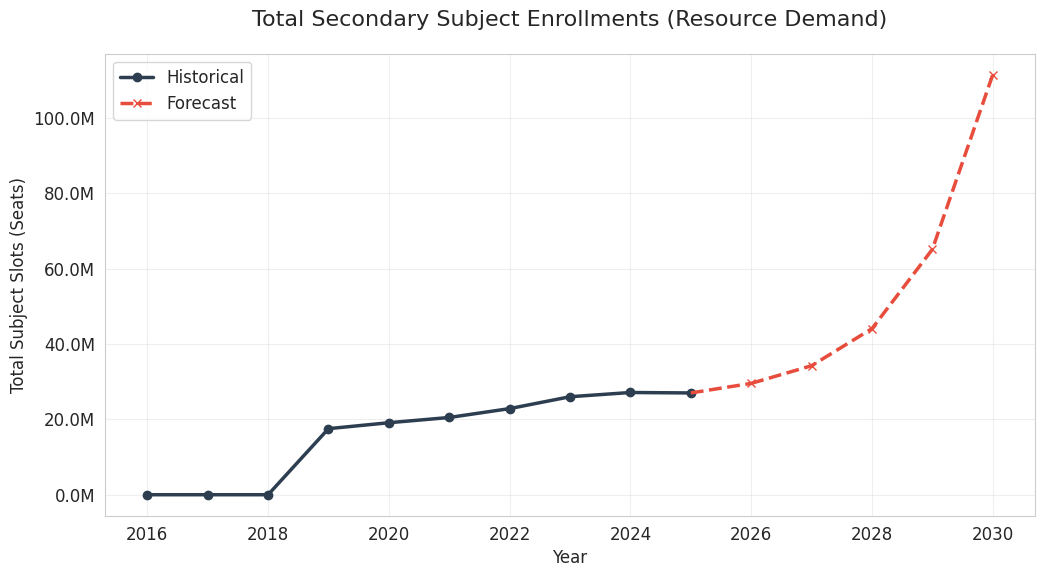

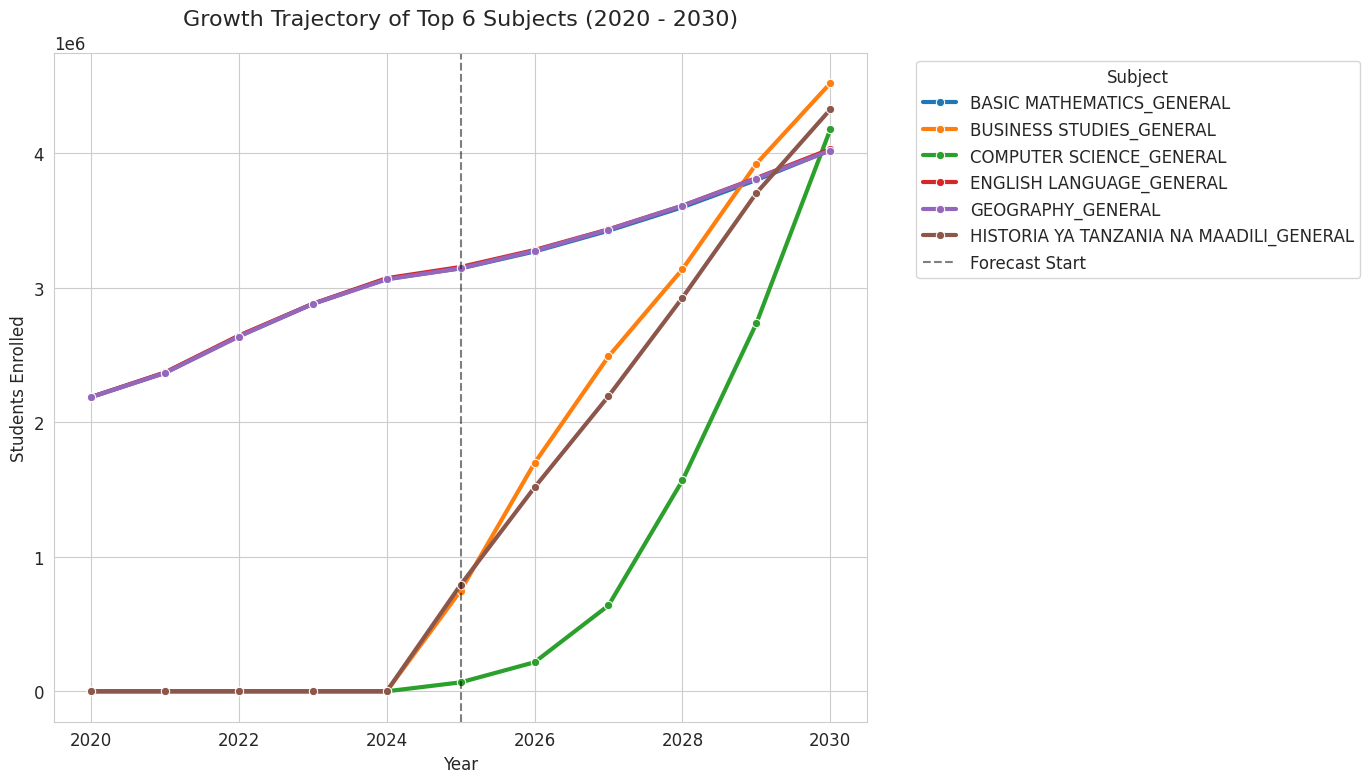

<Figure size 1200x700 with 0 Axes>

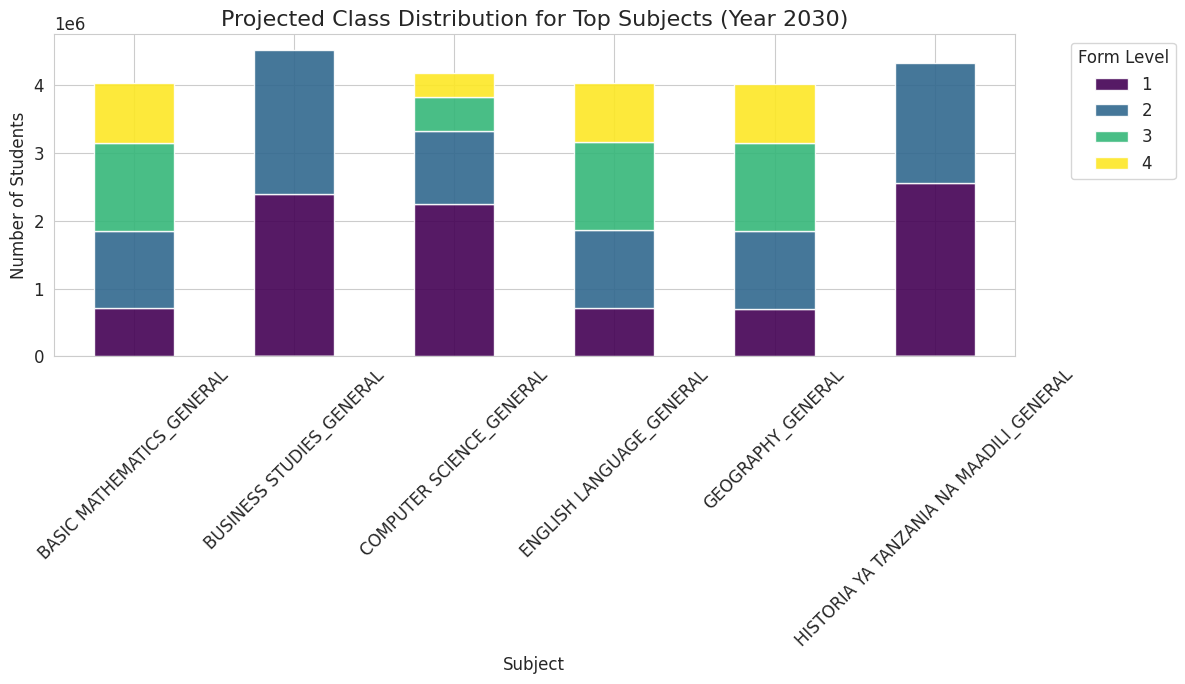


Success! Subject Forecast data saved to 'Tanzania_Secondary_Subject_Forecast_2026_2030.csv'


In [41]:
# ==========================================
# MASTER EXECUTION BLOCK (SUBJECT-LEVEL)
# ==========================================

# 1. PREPARE HISTORICAL DATA (Required for Plotting)
print("STEP 1: Preparing Historical Subject Data (2016-2025)...")
# We call the prep function explicitly here to get the 'history' dataframe for charts
subject_history_df = prepare_subject_data(
    loaded_dataframes["Secondary_students_per_subject"],
    loaded_dataframes["Dropout-Secondary  2017-2024"],
    loaded_dataframes["Data-Secondary Tables and chairs 2016-2025"],
    loaded_dataframes["Secondary-Re_entry"],
    loaded_dataframes["Secondary - DISABALITY 2020-2025"],
    loaded_dataframes["Combined_Secondary_ICT_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Electricity_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Laboratories_All_G_NG"]
)

# 2. GENERATE FORECASTS (2026-2030)
print("\nSTEP 2: Running Recursive Subject Forecast Engine...")
# This runs the training and recursive prediction loop
future_subject_enrollment = run_subject_forecast_system(
    loaded_dataframes["Secondary_students_per_subject"],
    loaded_dataframes["Dropout-Secondary  2017-2024"],
    loaded_dataframes["Data-Secondary Tables and chairs 2016-2025"],
    loaded_dataframes["Secondary-Re_entry"],
    loaded_dataframes["Secondary - DISABALITY 2020-2025"],
    loaded_dataframes["Combined_Secondary_ICT_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Electricity_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Laboratories_All_G_NG"]
)

# 3. SHOW HEAD OF FORECAST DATA
print("\nSTEP 3: Preview of Subject Forecast Data (First 10 Rows):")
pd.set_option('display.max_columns', None)
print(future_subject_enrollment.head(10))

# 4. PLOT & SAVE GRAPHS
print("\nSTEP 4: Generating Subject Trends & Popularity Charts...")
# Plots: Total Seats Needed, Science vs. Arts Growth, and Form Distribution
plot_subject_forecasts(subject_history_df, future_subject_enrollment)

# 5. EXPORT DATA TO CSV
csv_filename = "Tanzania_Secondary_Subject_Forecast_2026_2030.csv"
future_subject_enrollment.to_csv(csv_filename, index=False)
print(f"\nSuccess! Subject Forecast data saved to '{csv_filename}'")

STEP 1: Preparing Historical Subject Data (2016-2025)...
Melting 283 subject columns...

STEP 2: Running Recursive Subject Forecast Engine...
STEP 1: Preparing Subject Data...
Melting 283 subject columns...
STEP 2: Training Models on 519588 rows...
STEP 3: Recursive Forecasting (2026-2030)...
 > 2026 Forecast Complete.
 > 2027 Forecast Complete.
 > 2028 Forecast Complete.
 > 2029 Forecast Complete.
 > 2030 Forecast Complete.

STEP 3: Preview of Subject Forecast Data (First 10 Rows):
   YEAR  REGION COUNCIL                         SUBJECT  FORM_NUM  ENROLLMENT
0  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         1           0
1  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         2           0
2  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         3           0
3  2026  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL         4           0
4  2026  ARUSHA  ARUSHA  ADDITIONAL MATHEMATICS_GENERAL         1           0
5  2026  ARUSHA  ARUSHA  ADDITIONAL MATHEMAT

/tmp/ipython-input-376558549.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.1f}M'.format(x/1e6) for x in current_values])


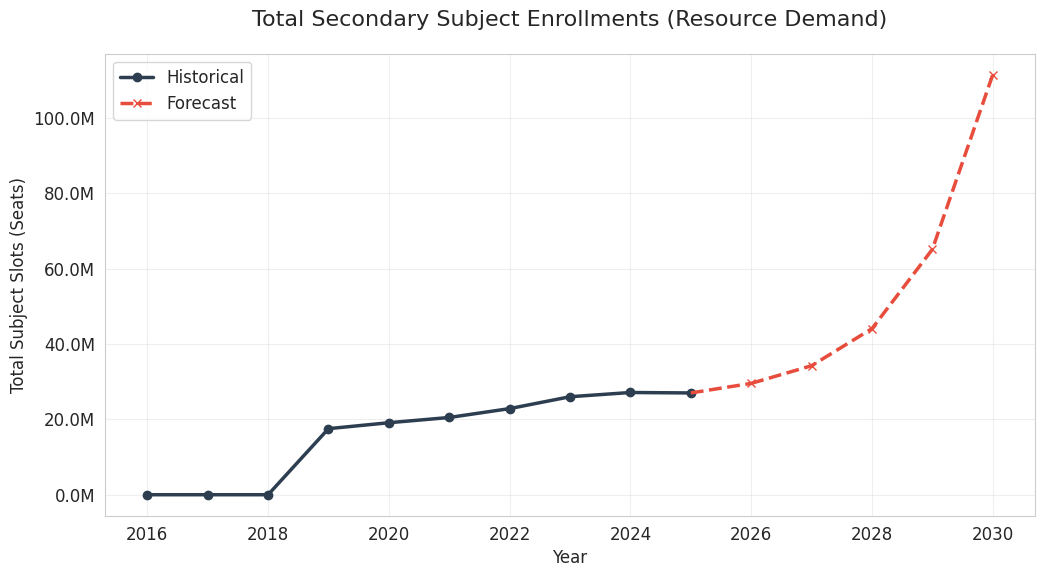

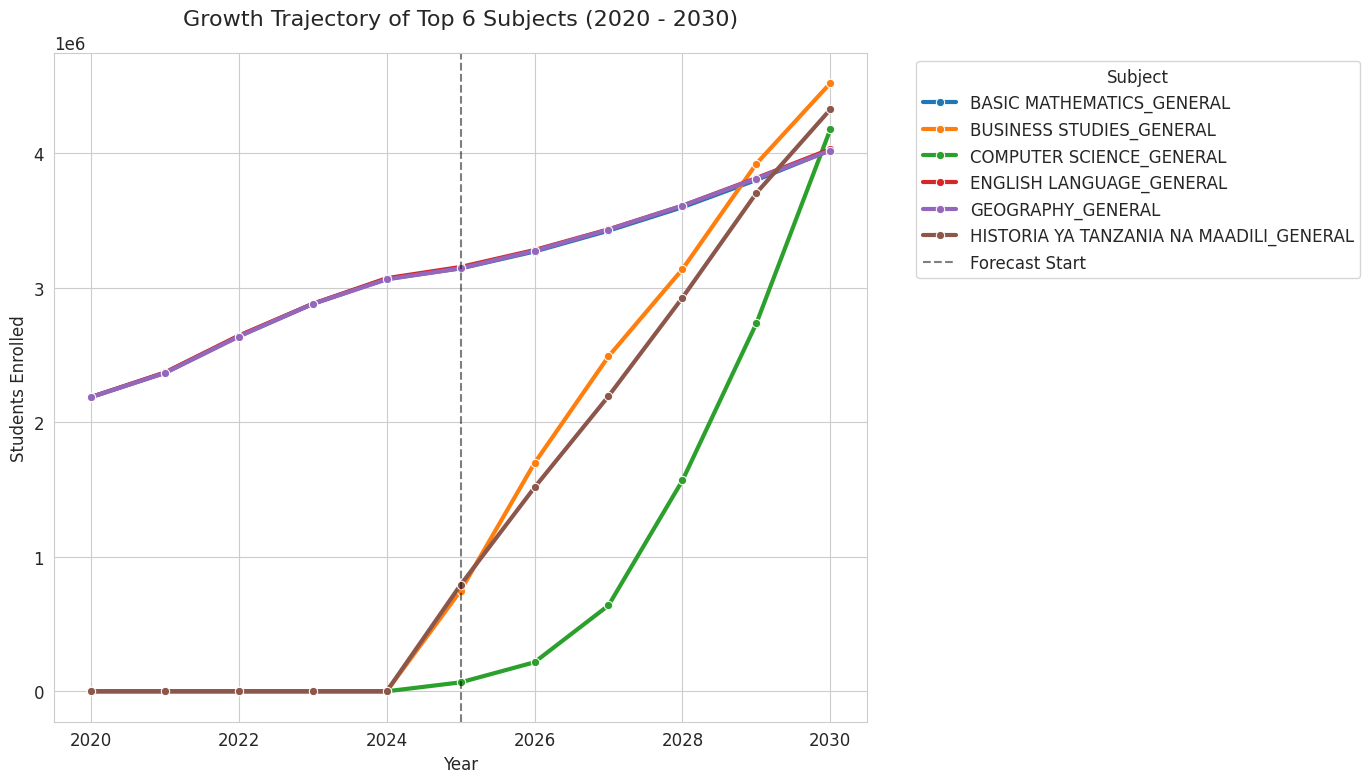

<Figure size 1200x700 with 0 Axes>

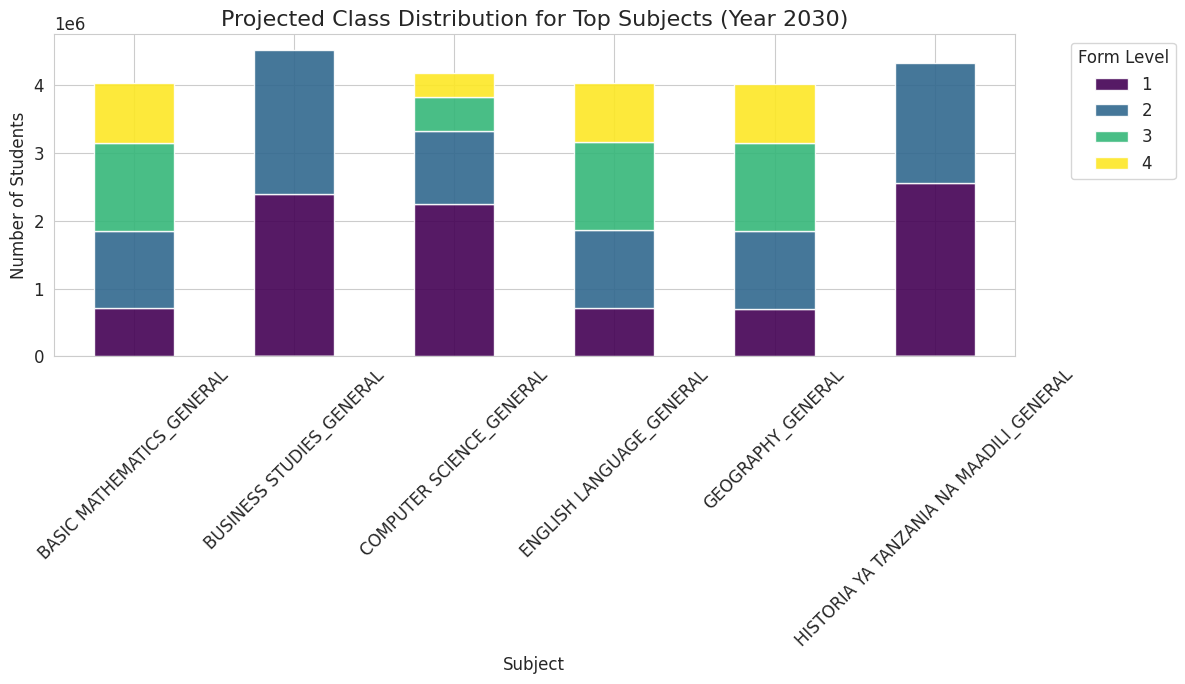


Success! Subject Forecast data saved to 'Tanzania_Secondary_Subject_Forecast_2026_2030.csv'


In [43]:
# ==========================================
# MASTER EXECUTION BLOCK (SUBJECT-LEVEL)
# ==========================================

# 1. PREPARE HISTORICAL DATA (Required for Plotting)
print("STEP 1: Preparing Historical Subject Data (2016-2025)...")
# We call the prep function explicitly here to get the 'history' dataframe for charts
subject_history_df = prepare_subject_data(
    loaded_dataframes["Secondary_students_per_subject"],
    loaded_dataframes["Dropout-Secondary  2017-2024"],
    loaded_dataframes["Data-Secondary Tables and chairs 2016-2025"],
    loaded_dataframes["Secondary-Re_entry"],
    loaded_dataframes["Secondary - DISABALITY 2020-2025"],
    loaded_dataframes["Combined_Secondary_ICT_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Electricity_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Laboratories_All_G_NG"]
)

# 2. GENERATE FORECASTS (2026-2030)
print("\nSTEP 2: Running Recursive Subject Forecast Engine...")
# This runs the training and recursive prediction loop
future_subject_enrollment = run_subject_forecast_system(
    loaded_dataframes["Secondary_students_per_subject"],
    loaded_dataframes["Dropout-Secondary  2017-2024"],
    loaded_dataframes["Data-Secondary Tables and chairs 2016-2025"],
    loaded_dataframes["Secondary-Re_entry"],
    loaded_dataframes["Secondary - DISABALITY 2020-2025"],
    loaded_dataframes["Combined_Secondary_ICT_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Electricity_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Laboratories_All_G_NG"]
)

# 3. SHOW HEAD OF FORECAST DATA
print("\nSTEP 3: Preview of Subject Forecast Data (First 10 Rows):")
pd.set_option('display.max_columns', None)
print(future_subject_enrollment.head(10))

# 4. PLOT & SAVE GRAPHS
print("\nSTEP 4: Generating Subject Trends & Popularity Charts...")
# Plots: Total Seats Needed, Science vs. Arts Growth, and Form Distribution
plot_subject_forecasts(subject_history_df, future_subject_enrollment)

# 5. EXPORT DATA TO CSV
csv_filename = "Tanzania_Secondary_Subject_Forecast_2026_2030.csv"
future_subject_enrollment.to_csv(csv_filename, index=False)
print(f"\nSuccess! Subject Forecast data saved to '{csv_filename}'")

In [44]:
# ==========================================
# TRANSFORM SUBJECT FORECAST TO WIDE FORMAT
# ==========================================

# 1. Pivot the Data
# Index: The static identifiers (Region, Council, Subject, Form)
# Columns: The years (2026, 2027, etc.)
# Values: The enrollment numbers
wide_subject_forecast = future_subject_enrollment.pivot_table(
    index=['REGION', 'COUNCIL', 'SUBJECT', 'FORM_NUM'],
    columns='YEAR',
    values='ENROLLMENT',
    aggfunc='sum'
)

# 2. Flatten the Column Headers
# Converts [2026, 2027...] to strings ["2026", "2027"...]
wide_subject_forecast.columns = [str(col) for col in wide_subject_forecast.columns]

# 3. Reset Index to flatten the row headers
wide_subject_forecast = wide_subject_forecast.reset_index()

# 4. Sort for Readability
# Hierarchy: Region -> Council -> Subject (A-Z) -> Form (1-6)
wide_subject_forecast = wide_subject_forecast.sort_values(
    ['REGION', 'COUNCIL', 'SUBJECT', 'FORM_NUM']
)

# 5. Optional: Map Form Numbers back to "FORM X" strings for report consistency
wide_subject_forecast['FORM_NAME'] = 'FORM ' + wide_subject_forecast['FORM_NUM'].astype(str)

# Reorder columns to put Form Name next to Form Num
cols = ['REGION', 'COUNCIL', 'SUBJECT', 'FORM_NAME'] + \
       [c for c in wide_subject_forecast.columns if c in ['2026','2027','2028','2029','2030']]

wide_subject_forecast = wide_subject_forecast[cols]

# 6. Display the Head
print("--- Wide Format Subject Forecast (First 10 Rows) ---")
pd.set_option('display.max_columns', None)
print(wide_subject_forecast.head(10))

# 7. Export to CSV
csv_filename = "Tanzania_Subject_Forecast_2026_2030_WIDE.csv"
wide_subject_forecast.to_csv(csv_filename, index=False)
print(f"\nSuccess! Wide-format Subject data saved to '{csv_filename}'")

--- Wide Format Subject Forecast (First 10 Rows) ---
   REGION COUNCIL                         SUBJECT FORM_NAME  2026  2027  2028  \
0  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL    FORM 1     0     5    27   
1  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL    FORM 2     0     0     0   
2  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL    FORM 3     0     0     0   
3  ARUSHA  ARUSHA             ACCOUNTANCY_GENERAL    FORM 4     0     0     0   
4  ARUSHA  ARUSHA  ADDITIONAL MATHEMATICS_GENERAL    FORM 1     0     5    27   
5  ARUSHA  ARUSHA  ADDITIONAL MATHEMATICS_GENERAL    FORM 2     0     0     0   
6  ARUSHA  ARUSHA  ADDITIONAL MATHEMATICS_GENERAL    FORM 3     0     0     0   
7  ARUSHA  ARUSHA  ADDITIONAL MATHEMATICS_GENERAL    FORM 4     0     0     0   
8  ARUSHA  ARUSHA    ADVANCED MATHEMATICS_GENERAL    FORM 1     0     5    27   
9  ARUSHA  ARUSHA    ADVANCED MATHEMATICS_GENERAL    FORM 2     0     0     0   

   2029  2030  
0   171   870  
1     0     0  
2     0


--- Running Pipeline to get Model Objects ---
1. Preparing Datasets...
2. Engineering Features...
3. Training Both Models...
Training XGBoost...
Training LightGBM...

Generating Feature Importance Comparison...
Graph saved as Secondary_Feature_Importance_Comparison.png


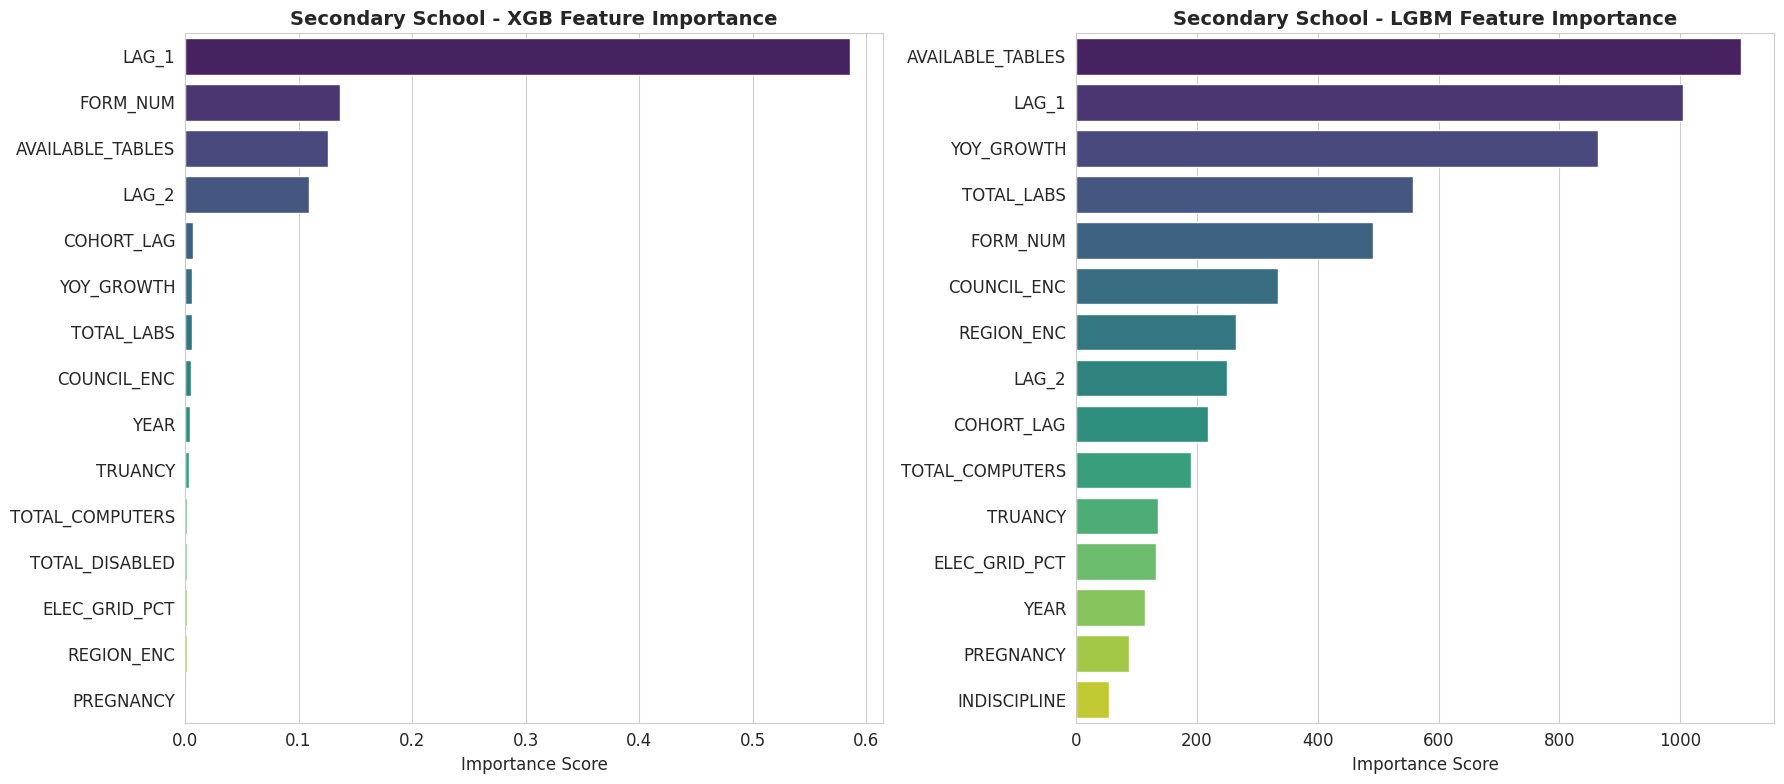

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================
# 1. UPDATE TRAINING FUNCTION TO RETURN BOTH MODELS
# ==========================================
def train_secondary_models_both(df):
    """
    Trains both XGBoost and LightGBM and returns them in a dictionary.
    """
    le = LabelEncoder()
    df['REGION_ENC'] = le.fit_transform(df['REGION'].astype(str))
    df['COUNCIL_ENC'] = le.fit_transform(df['COUNCIL'].astype(str))

    features = [
        'YEAR', 'REGION_ENC', 'COUNCIL_ENC', 'FORM_NUM',
        'AVAILABLE_TABLES', 'TOTAL_REENTRY', 'TOTAL_DISABLED',
        'TOTAL_COMPUTERS', 'ELEC_GRID_PCT', 'TOTAL_LABS',
        'TRUANCY', 'PREGNANCY', 'INDISCIPLINE',
        'LAG_1', 'LAG_2', 'YOY_GROWTH', 'COHORT_LAG', 'IS_ELECTION_YEAR'
    ]

    # Filter features
    features = [f for f in features if f in df.columns]

    train = df[df['YEAR'] < 2024]
    test = df[df['YEAR'] >= 2024]

    X_train, y_train = train[features], train['ENROLLMENT']
    X_test, y_test = test[features], test['ENROLLMENT']

    results = {}
    models = {} # <--- Dictionary to store both models

    # 1. XGBoost
    print("Training XGBoost...")
    xgb_model = xgb.XGBRegressor(n_estimators=150, max_depth=7, learning_rate=0.05)
    xgb_model.fit(X_train, y_train)
    models['XGB'] = xgb_model

    # 2. LightGBM
    print("Training LightGBM...")
    lgb_model = lgb.LGBMRegressor(n_estimators=150, num_leaves=40, verbose=-1)
    lgb_model.fit(X_train, y_train)
    models['LGBM'] = lgb_model

    return results, models

# ==========================================
# 2. UPDATE PIPELINE TO CAPTURE MODEL DICTIONARY
# ==========================================
def run_secondary_pipeline_both(enroll_df, drop_df, table_df, reentry_df, dis_df, ict_df, elec_df, labs_df):

    # Reuse the preparation functions defined earlier
    print("1. Preparing Datasets...")
    enroll, drops, tables, reentry, dis, ict, elec, labs = prepare_secondary_datasets(
        enroll_df, drop_df, table_df, reentry_df, dis_df, ict_df, elec_df, labs_df
    )

    print("2. Engineering Features...")
    final_df = engineer_secondary_features(enroll, drops, tables, reentry, dis, ict, elec, labs)

    print("3. Training Both Models...")
    metrics, models = train_secondary_models_both(final_df)

    return final_df, models

# ==========================================
# 3. EXECUTION: GET MODELS & PLOT
# ==========================================

# A. Run Pipeline
print("\n--- Running Pipeline to get Model Objects ---")
sec_final_df, sec_models_dict = run_secondary_pipeline_both(
    loaded_dataframes["Data-Secondary Enrollment 2016-2025"],
    loaded_dataframes["Dropout-Secondary  2017-2024"],
    loaded_dataframes["Data-Secondary Tables and chairs 2016-2025"],
    loaded_dataframes["Secondary-Re_entry"],
    loaded_dataframes["Secondary - DISABALITY 2020-2025"],
    loaded_dataframes["Combined_Secondary_ICT_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Electricity_All_G_NG"],
    loaded_dataframes["Combined_Secondary_Laboratories_All_G_NG"]
)

# B. Define Plotting Function (Original Style)
def plot_feature_importance(models_dict, model_names=['XGB', 'LGBM'], title_prefix=""):
    sns.set_style("whitegrid")

    # Setup Subplots
    fig, axes = plt.subplots(1, len(model_names), figsize=(18, 8))
    if len(model_names) == 1: axes = [axes]

    for i, name in enumerate(model_names):
        model = models_dict.get(name)
        if not model: continue

        # Extract Importances based on library
        if name == 'XGB':
            importance = model.feature_importances_
            feats = model.feature_names_in_
        elif name == 'LGBM':
            importance = model.feature_importances_
            feats = model.feature_name_
        else:
            continue

        # Create DataFrame & Sort
        imp_df = pd.DataFrame({'Feature': feats, 'Importance': importance})
        imp_df = imp_df.sort_values('Importance', ascending=False).head(15) # Top 15

        # Plot
        sns.barplot(data=imp_df, x='Importance', y='Feature', ax=axes[i], palette='viridis')
        axes[i].set_title(f'{title_prefix} - {name} Feature Importance', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Importance Score')
        axes[i].set_ylabel('')

    plt.tight_layout()
    plt.savefig("Secondary_Feature_Importance_Comparison.png", dpi=300)
    print("Graph saved as Secondary_Feature_Importance_Comparison.png")
    plt.show()

# C. Generate the Graphs
print("\nGenerating Feature Importance Comparison...")
plot_feature_importance(sec_models_dict, title_prefix="Secondary School")

In [ ]:
import pandas as pd

# ==========================================
# MERGE HISTORY & FORECAST (SECONDARY SCHOOLS)
# ==========================================

# Define common columns for concatenation
# Note: Using 'FORM' instead of 'GRADE' for Secondary Schools
common_cols = ['YEAR', 'REGION', 'COUNCIL', 'FORM', 'ENROLLMENT']

# 1. Select common columns from the historical dataset (secondary_final_df)
# We ensure we only take the columns that match the forecast structure
historical_sec_selected = secondary_final_df[common_cols].copy()

# 2. Select common columns from the forecast dataset (future_secondary_enrollment)
forecast_sec_selected = future_secondary_enrollment[common_cols].copy()

# 3. Concatenate History + Forecast
total_secondary_enrollment_forecast = pd.concat([
    historical_sec_selected,
    forecast_sec_selected
], ignore_index=True)

# 4. Sort for clean reading
# Sort by Year -> Region -> Council -> Form
total_secondary_enrollment_forecast = total_secondary_enrollment_forecast.sort_values(
    ['YEAR', 'REGION', 'COUNCIL', 'FORM']
)

print("--- Combined Secondary Historical and Forecasted Data ---")
print("First 5 rows (Historical Start):")
print(total_secondary_enrollment_forecast.head())

print("\nLast 5 rows (Forecast End):")
print(total_secondary_enrollment_forecast.tail())

print("\nDataFrame Info:")
total_secondary_enrollment_forecast.info()

# 5. Optional: Export the Master Dataset
csv_filename = "Tanzania_Secondary_Master_Dataset_2016_2030.csv"
total_secondary_enrollment_forecast.to_csv(csv_filename, index=False)
print(f"\nSuccess! Master dataset saved to '{csv_filename}'")

--- Combined Secondary Historical and Forecasted Data ---
First 5 rows (Historical Start):
    YEAR  REGION COUNCIL    FORM  ENROLLMENT
0   2016  ARUSHA  ARUSHA  FORM 1        6950
10  2016  ARUSHA  ARUSHA  FORM 2        5797
20  2016  ARUSHA  ARUSHA  FORM 3        3958
30  2016  ARUSHA  ARUSHA  FORM 4        4928
40  2016  ARUSHA  ARUSHA  FORM 5         709

Last 5 rows (Forecast End):
       YEAR REGION   COUNCIL    FORM  ENROLLMENT
16531  2030  TANGA  TANGA CC  FORM 2        6757
16532  2030  TANGA  TANGA CC  FORM 3       11779
16533  2030  TANGA  TANGA CC  FORM 4        6957
16534  2030  TANGA  TANGA CC  FORM 5        1274
16535  2030  TANGA  TANGA CC  FORM 6        1207

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 16536 entries, 0 to 16535
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   YEAR        16536 non-null  int64 
 1   REGION      16536 non-null  object
 2   COUNCIL     16536 non-null  obj

In [ ]:
import pandas as pd

# ==========================================
# RANDOM SAMPLING OF COUNCILS (SECONDARY)
# ==========================================

total_selected = 24

# 1. Identify all unique 'REGION' and 'COUNCIL' combinations from the Master Secondary Dataset
unique_sec_councils = total_secondary_enrollment_forecast[['REGION', 'COUNCIL']].drop_duplicates()

# 2. Randomly sample 'total_selected' of these unique combinations
#    We use random_state=42 to ensure we get the same "random" councils every time we run this.
selected_sec_councils = unique_sec_councils.sample(n=total_selected, random_state=42)

# 3. Display the selected councils to verify
print(f"--- Randomly Selected {total_selected} Secondary School Councils ---")
print(selected_sec_councils)

# Optional: Store as a list of tuples for easy filtering later
# Example format: [('ARUSHA', 'ARUSHA CC'), ('DODOMA', 'BAHI DC'), ...]
selected_sec_councils_list = [tuple(row) for row in selected_sec_councils.values]

--- Randomly Selected 24 Secondary School Councils ---
            REGION              COUNCIL
1248         GEITA                CHATO
2628        KIGOMA              BUHIGWE
9522      SINGIDA            SINGIDA MC
6768        MWANZA              UKEREWE
9042        SIMIYU                MASWA
1008        DODOMA            KONDOA TC
1548        IRINGA               IRINGA
4188       MANYARA             MBULU TC
7128        NJOMBE         WANGING'OMBE
5988        MTWARA  MTWARA MIKINDANI MC
5928        MTWARA               MTWARA
9936        TABORA               KALIUA
4248       MANYARA            SIMANJIRO
10656        TANGA           KOROGWE TC
2808        KIGOMA            KASULU TC
1068        DODOMA               KONGWA
3168   KILIMANJARO                MOSHI
2208        KAGERA               MULEBA
5028         MBEYA              MBARALI
3468   KILIMANJARO                 SIHA
10056       TABORA             NZEGA TC
7602         PWANI             MKURANGA
8922        SIMIYU       

--- Generating Secondary Enrollment Plots for 24 Selected Councils (2016-2030) ---
Graph saved as 'Secondary_Selected_Councils_Trends.png'


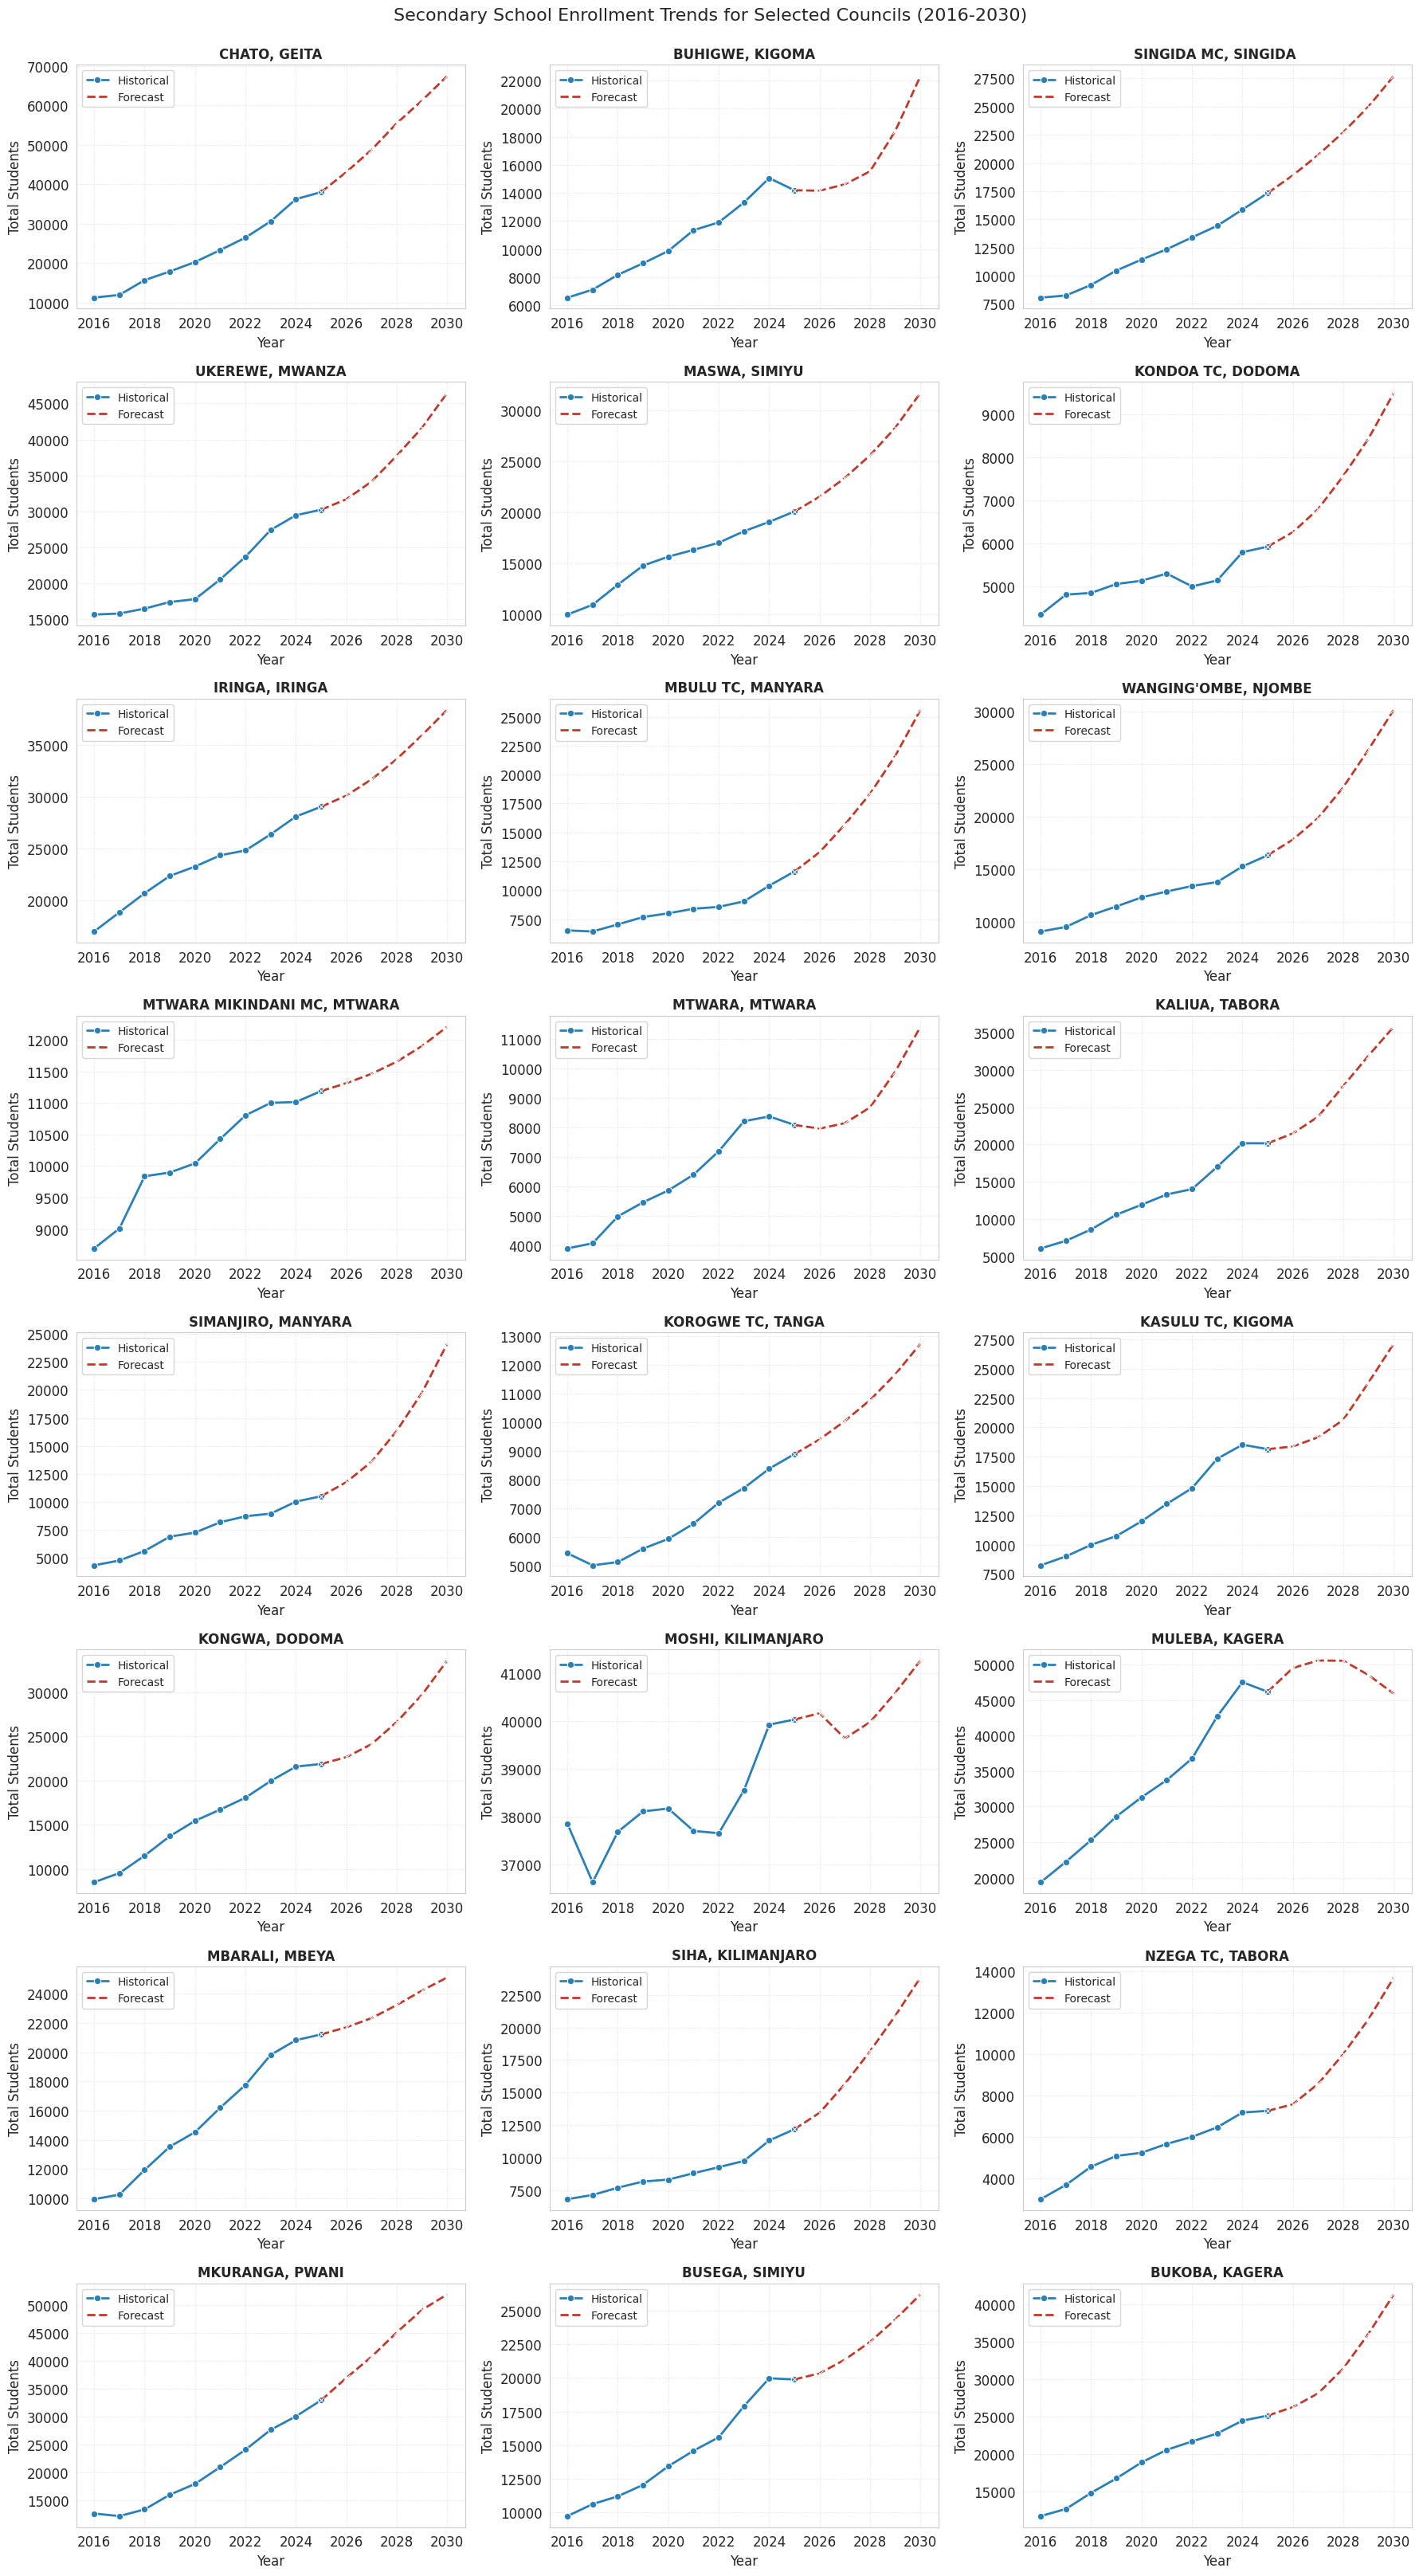

--- All secondary enrollment trend visualizations generated. ---


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Ensure numpy is imported for ceil calculation

sns.set_style("whitegrid")

# ==========================================
# PLOT TRENDS FOR SELECTED SECONDARY COUNCILS
# ==========================================

# 1. Calculate total enrollment per year for each council
# Summing across all Forms (1-6) to get a single trend line per council
sec_council_totals = total_secondary_enrollment_forecast.groupby(['REGION', 'COUNCIL', 'YEAR'])['ENROLLMENT'].sum().reset_index()

# 2. Determine grid dimensions (3 columns wide)
num_councils = len(selected_sec_councils_list)
rows = int(np.ceil(num_councils / 3))
cols = 3

# 3. Initialize Figure
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), sharex=False, sharey=False)
axes = axes.flatten() # Flatten 2D array to 1D for easy iteration

print(f"--- Generating Secondary Enrollment Plots for {num_councils} Selected Councils (2016-2030) ---")

# 4. Loop through selected councils and plot
for i, (region, council) in enumerate(selected_sec_councils_list):
    ax = axes[i]

    # Filter data specific to this council
    council_data = sec_council_totals[
        (sec_council_totals['REGION'] == region) &
        (sec_council_totals['COUNCIL'] == council)
    ].sort_values('YEAR')

    # A. Plot Historical (Up to 2025)
    historical_data = council_data[council_data['YEAR'] <= 2025]
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=historical_data, ax=ax,
                 label='Historical', color='#2980b9', marker='o', linewidth=2)

    # B. Plot Forecast (2025 onwards to ensure connection)
    forecast_data = council_data[council_data['YEAR'] >= 2025]
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=forecast_data, ax=ax,
                 label='Forecast', color='#c0392b', linestyle='--', marker='x', linewidth=2)

    # Formatting
    ax.set_title(f'{council}, {region}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Students')
    ax.legend(loc='upper left', fontsize='small')
    ax.grid(True, linestyle=':', alpha=0.6)

    # Improve X-axis ticks (every 2 years to avoid crowding)
    ax.set_xticks(np.arange(2016, 2031, 2))

# 5. Hide empty subplots if 24 doesn't fill the grid perfectly (though 24/3 = 8 rows exactly)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Secondary School Enrollment Trends for Selected Councils (2016-2030)', y=1.01, fontsize=16)

# Save the grid image
plt.savefig("Secondary_Selected_Councils_Trends.png", dpi=200, bbox_inches='tight')
print("Graph saved as 'Secondary_Selected_Councils_Trends.png'")

plt.show()

print("--- All secondary enrollment trend visualizations generated. ---")

In [ ]:
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64
import pandas as pd
import numpy as np
from folium import IFrame

# ---------------------------------------------------------
# 1. PREPARE SECONDARY DATA
# ---------------------------------------------------------
# First, ensure we have the aggregated totals per council (Summing Forms 1-6)
# We reuse the master dataset 'total_secondary_enrollment_forecast'
sec_council_totals = total_secondary_enrollment_forecast.groupby(
    ['REGION', 'COUNCIL', 'YEAR']
)['ENROLLMENT'].sum().reset_index()

# Filter to only include the 24 councils in 'selected_sec_councils_list'
selected_indices = [
    (row['REGION'], row['COUNCIL']) in selected_sec_councils_list
    for _, row in sec_council_totals.iterrows()
]
filtered_sec_forecast = sec_council_totals[selected_indices].copy()

# Merge with Geo Data to get Lat/Lon
# We group by Region/Council first to get one unique row per council for the map loop
sec_map_data = filtered_sec_forecast.groupby(['REGION', 'COUNCIL']).first().reset_index()

# NOTE: Assumes 'geo_data_final' exists in your environment with Lat/Lon
sec_map_data = pd.merge(
    sec_map_data,
    geo_data_final[['Region', 'Council', 'Latitude', 'Longitude']],
    left_on=['REGION', 'COUNCIL'],
    right_on=['Region', 'Council'],
    how='inner'
)

print(f"Matched coordinates for {len(sec_map_data)} out of {len(selected_sec_councils_list)} selected councils.")

# ---------------------------------------------------------
# 2. HELPER FUNCTION: PLOT TO HTML IMAGE
# ---------------------------------------------------------
def get_sec_plot_as_html(region, council, df_all):
    """
    Generates a matplotlib plot for a specific council and returns
    it as a base64 encoded HTML image string.
    """
    # Filter data for this specific council
    council_data = df_all[
        (df_all['REGION'] == region) &
        (df_all['COUNCIL'] == council)
    ].sort_values('YEAR')

    historical = council_data[council_data['YEAR'] <= 2025]
    forecast = council_data[council_data['YEAR'] >= 2025] # Overlap 2025 for continuity

    # Create figure (smaller size for popup)
    fig, ax = plt.subplots(figsize=(5, 3))

    # Plotting (Blue for History, Red for Forecast)
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=historical, ax=ax,
                 label='Hist', color='#2980b9', marker='o', markersize=4)
    sns.lineplot(x='YEAR', y='ENROLLMENT', data=forecast, ax=ax,
                 label='Fcst', color='#c0392b', linestyle='--', marker='x', markersize=4)

    # Styling
    ax.set_title(f'{council} Secondary Trend', fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(fontsize=8, loc='upper left')

    # Improve X-axis ticks (skip every other year if crowded)
    ax.set_xticks(np.arange(2016, 2031, 2))

    plt.tight_layout()

    # Save plot to PNG image in memory
    img = io.BytesIO()
    plt.savefig(img, format='png', bbox_inches='tight', dpi=100)
    plt.close(fig) # Close to free memory
    img.seek(0)

    # Encode to Base64 string
    encoded = base64.b64encode(img.getvalue()).decode()
    html = f'<img src="data:image/png;base64,{encoded}">'
    return html

# ---------------------------------------------------------
# 3. GENERATE MAP
# ---------------------------------------------------------
# Center map on Tanzania
sec_forecast_map = folium.Map(location=[-6.3690, 34.8888], zoom_start=6, tiles='CartoDB positron')

print("Generating map with embedded secondary plots... this may take a moment.")

for idx, row in sec_map_data.iterrows():
    reg = row['REGION']
    coun = row['COUNCIL']
    lat = row['Latitude']
    lon = row['Longitude']

    # Generate the plot HTML for this specific council using the full trend data
    plot_html = get_sec_plot_as_html(reg, coun, filtered_sec_forecast)

    # Create an IFrame to hold the image
    iframe = IFrame(plot_html, width=520, height=320)
    popup = folium.Popup(iframe, max_width=550)

    # Add Marker (Purple color to distinguish from Primary Schools)
    folium.Marker(
        location=[lat, lon],
        popup=popup,
        tooltip=f"{coun} (Secondary Forecast)",
        icon=folium.Icon(color='purple', icon='graduation-cap', prefix='fa')
    ).add_to(sec_forecast_map)

print("Secondary School Map generated successfully.")

# ---------------------------------------------------------
# 4. SAVE & DISPLAY MAP
# ---------------------------------------------------------
# Save to HTML file
sec_forecast_map.save("Secondary_Enrollment_Forecast_Map.html")
print("Map saved to 'Secondary_Enrollment_Forecast_Map.html'")

# Display in Notebook
sec_forecast_map

Matched coordinates for 23 out of 24 selected councils.
Generating map with embedded secondary plots... this may take a moment.
Secondary School Map generated successfully.
Map saved to 'Secondary_Enrollment_Forecast_Map.html'
